In [72]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import glob

# For RMSD, alignment, contacts, and hydrogen bond analysis
from MDAnalysis.analysis import rms, align, distances
#from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis
from scipy.interpolate import interp1d

In [73]:
def compute_ligand_rmsd(psf_file, dcd_file, ref_universe, ligand_select="resid 3 and resname HT1", frame_step=5):
    """
    计算配体相对于参考结构的 RMSD。
    
    参数：
    - psf_file (str): PSF 文件路径。
    - dcd_file (str): DCD 轨迹文件路径。
    - ref_universe (Universe): 对齐参考的 Universe。
    - ligand_select (str): 配体选择字符串。
    - frame_step (int): 帧间隔 (默认每 5 帧读取一次)。
    
    返回：
    - times (np.array): 轨迹中的时间数组。
    - rmsd_vals (np.array): 配体的 RMSD 值数组。
    """
    import numpy as np
    import MDAnalysis as mda
    from MDAnalysis.analysis import align, rms
    
    # 加载移动的 Universe
    mobile = mda.Universe(psf_file, dcd_file)
    
    # 选择配体
    ref_lig = ref_universe.select_atoms(ligand_select)
    mobile_lig = mobile.select_atoms(ligand_select)
    
    # 确保配体存在
    if ref_lig.n_atoms == 0:
        raise ValueError(f"参考结构中未找到配体 ({ligand_select})。")
    if mobile_lig.n_atoms == 0:
        raise ValueError(f"轨迹 {dcd_file} 中未找到配体 ({ligand_select})。")
    
    # 对齐移动轨迹到参考结构
    aligner = align.AlignTraj(mobile, ref_universe, select="protein and backbone", in_memory=True)
    aligner.run()
    
    # 计算 RMSD
    rmsd_vals = []
    times = []
    for ts in mobile.trajectory[::frame_step]:  # Read every `frame_step` frame
        rmsd = rms.rmsd(mobile_lig.positions, ref_lig.positions, center=True, superposition=False)
        rmsd_vals.append(rmsd)
        times.append(ts.time)
#        print(f"Processing frame {ts.frame}, time {ts.time:.2f} ps")  # Debug: Print frame and time
    
    return np.array(times), np.array(rmsd_vals)


In [74]:
# WT 文件路径
wt_psf = "/Scr/msincla01/BmrCD/of-state/analysis/trajs/rep1.psf"
wt_dcd_list = [
    "/Scr/msincla01/BmrCD/of-state/analysis/trajs/rep1.dcd",
    "/Scr/msincla01/BmrCD/of-state/analysis/trajs/rep2.dcd",
    "/Scr/msincla01/BmrCD/of-state/analysis/trajs/rep4.dcd"
]

# Mutant 文件路径
mut_psf = "/Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep1.psf"
mut_dcd_list = [
    "/Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep1.dcd",
    "/Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep2.dcd",
    "/Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep3.dcd"
]


In [75]:
# 加载 WT 参考结构（第一复制的第一帧）
wt_ref_universe = mda.Universe(wt_psf, wt_dcd_list[0])
wt_ref_universe.trajectory[0]  # 确保在第一帧

# 选择配体
wt_ref_lig = wt_ref_universe.select_atoms("resid 3 and resname HT1")
print(f"WT 参考配体原子数量：{wt_ref_lig.n_atoms}")

# 加载 Mutant 参考结构（第一复制的第一帧）
mut_ref_universe = mda.Universe(mut_psf, mut_dcd_list[0])
mut_ref_universe.trajectory[0]  # 确保在第一帧

# 选择配体
mut_ref_lig = mut_ref_universe.select_atoms("resid 3 and resname HT1")
print(f"Mutant 参考配体原子数量：{mut_ref_lig.n_atoms}")


/Scr/yunsenz2/data/software/miniconda3/envs/mdanalysis/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


WT 参考配体原子数量：64
Mutant 参考配体原子数量：64


In [76]:
# 初始化存储 RMSD 和时间数据
wt_rmsd_list = []
wt_time_list = []

mut_rmsd_list = []
mut_time_list = []

# 处理 WT 轨迹
for i, dcd in enumerate(wt_dcd_list, 1):
    try:
        print(f"正在处理 WT 复制 {i}: {dcd}")
        times, rmsd = compute_ligand_rmsd(wt_psf, dcd, wt_ref_universe, ligand_select="resid 3 and resname HT1")
        wt_rmsd_list.append(rmsd)
        wt_time_list.append(times)
    except Exception as e:
        print(f"处理 WT 复制 {i} 时出错: {e}")

# 处理 Mutant 轨迹
for i, dcd in enumerate(mut_dcd_list, 1):
    try:
        print(f"正在处理 Mutant 复制 {i}: {dcd}")
        times, rmsd = compute_ligand_rmsd(mut_psf, dcd, mut_ref_universe, ligand_select="resid 3 and resname HT1")
        mut_rmsd_list.append(rmsd)
        mut_time_list.append(times)
    except Exception as e:
        print(f"处理 Mutant 复制 {i} 时出错: {e}")


正在处理 WT 复制 1: /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep1.dcd
正在处理 WT 复制 2: /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep2.dcd
正在处理 WT 复制 3: /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep4.dcd
正在处理 Mutant 复制 1: /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep1.dcd
正在处理 Mutant 复制 2: /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep2.dcd
正在处理 Mutant 复制 3: /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep3.dcd


In [77]:
# 确定统一的时间网格
# 找到所有复制的最大时间
all_times = np.concatenate(wt_time_list + mut_time_list)
min_time = all_times.min()
max_time = all_times.max()
time_step = 1.0  # 1 ps 时间步长

uniform_time = np.arange(min_time, max_time + time_step, time_step)

# 初始化列表存储插值后的 RMSD
wt_rmsd_interp = []
mut_rmsd_interp = []

# 插值 WT RMSD 数据
for times, rmsd in zip(wt_time_list, wt_rmsd_list):
    # 创建插值函数
    interp_func = interp1d(times, rmsd, kind='linear', bounds_error=False, fill_value=np.nan)
    # 计算插值 RMSD
    rmsd_uniform = interp_func(uniform_time)
    wt_rmsd_interp.append(rmsd_uniform)

# 插值 Mutant RMSD 数据
for times, rmsd in zip(mut_time_list, mut_rmsd_list):
    # 创建插值函数
    interp_func = interp1d(times, rmsd, kind='linear', bounds_error=False, fill_value=np.nan)
    # 计算插值 RMSD
    rmsd_uniform = interp_func(uniform_time)
    mut_rmsd_interp.append(rmsd_uniform)


In [78]:
# 转换为 NumPy 数组
wt_rmsd_interp = np.array(wt_rmsd_interp)  # 形状：(n_replicates, n_time_points)
mut_rmsd_interp = np.array(mut_rmsd_interp)

# 计算均值和标准差，忽略 NaN
wt_rmsd_mean = np.nanmean(wt_rmsd_interp, axis=0)
wt_rmsd_std = np.nanstd(wt_rmsd_interp, axis=0)

mut_rmsd_mean = np.nanmean(mut_rmsd_interp, axis=0)
mut_rmsd_std = np.nanstd(mut_rmsd_interp, axis=0)


/tmp/ipykernel_3565795/1119157982.py:6: RuntimeWarning: Mean of empty slice
  wt_rmsd_mean = np.nanmean(wt_rmsd_interp, axis=0)
/Scr/yunsenz2/data/software/miniconda3/envs/mdanalysis/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3565795/1119157982.py:9: RuntimeWarning: Mean of empty slice
  mut_rmsd_mean = np.nanmean(mut_rmsd_interp, axis=0)


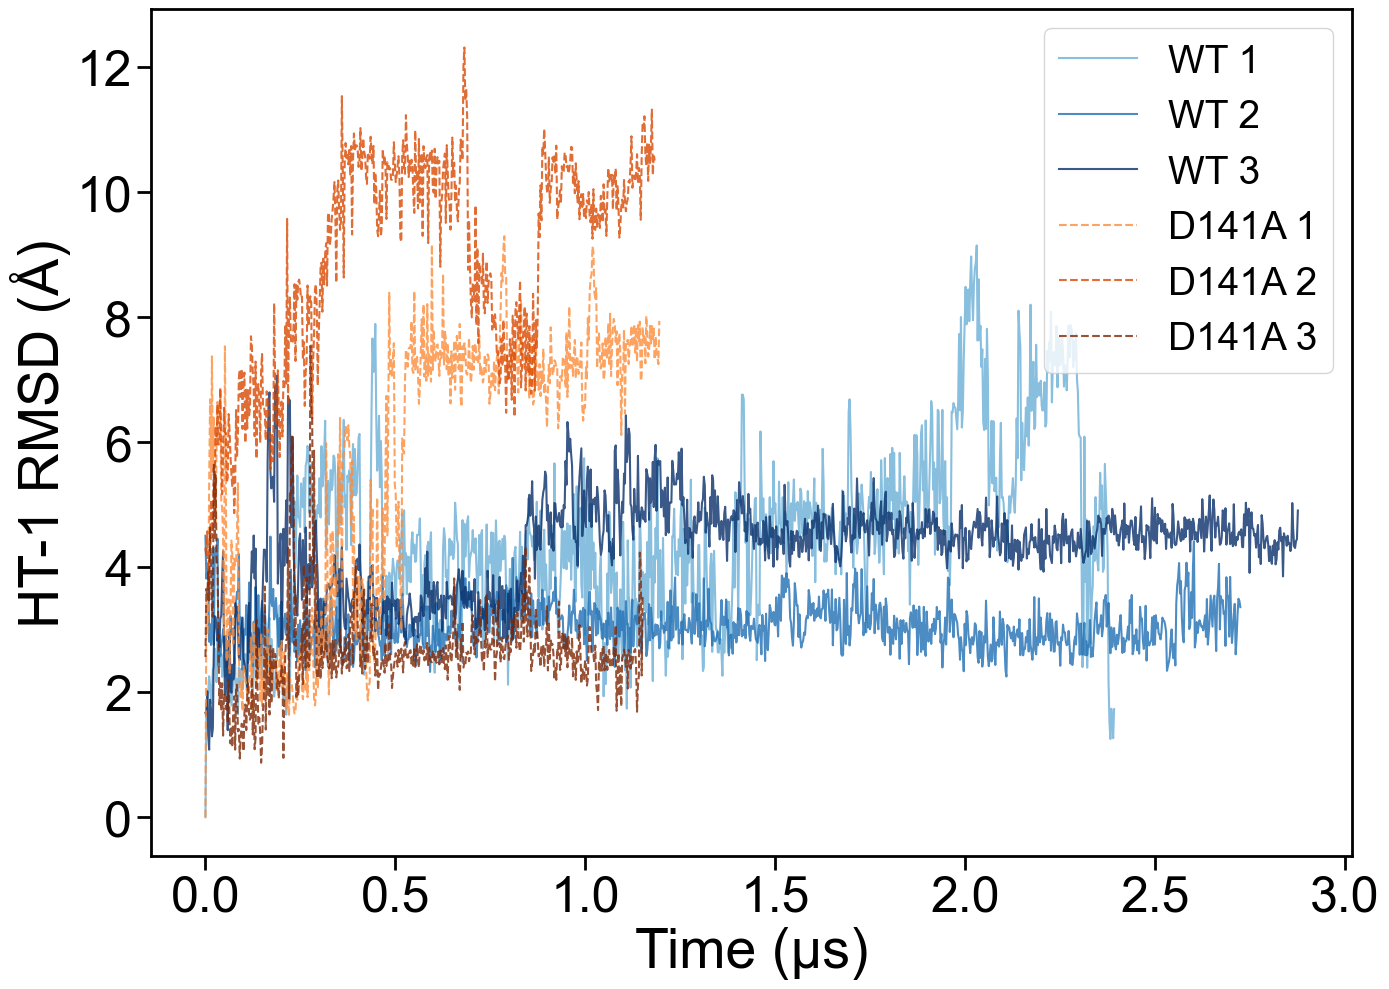

In [79]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.ticker import FuncFormatter
from matplotlib import font_manager

# Assume wt_time_list, wt_rmsd_list, mut_time_list, mut_rmsd_list are already defined
factor = 0.01 # The scaling factor for the x-axis

plt.figure(figsize=(14, 10))
save_path = "/Scr/yunsenz2/data/BmrCD/figure/HT1_RMSD_plot.png"
# Define the colormaps for WT and Mutant replicas
wt_colors = cm.Blues(np.linspace(0.5, 1, len(wt_time_list)))  # Shades of blue for WT
mut_colors = cm.Oranges(np.linspace(0.5, 1, len(mut_time_list)))  # Shades of orange for Mutant

# Plot WT replicas with unique colors
for i, (times, rmsd) in enumerate(zip(wt_time_list, wt_rmsd_list), 1):
    plt.plot(times, rmsd, label=f"WT {i}", color=wt_colors[i - 1], alpha=0.8)

# Plot Mutant replicas with unique colors
for i, (times, rmsd) in enumerate(zip(mut_time_list, mut_rmsd_list), 1):
    plt.plot(times, rmsd, label=f"D141A {i}", color=mut_colors[i - 1], linestyle='--', alpha=0.8)

# Add labels
plt.xlabel("Time (μs)", fontsize=40, fontname='Arial')
plt.ylabel("HT-1 RMSD (Å)", fontsize=40, fontname='Arial')
plt.xticks(fontsize=36, fontname='Arial')
plt.yticks(fontsize=36, fontname='Arial')

# Make the border thicker
ax = plt.gca()  # Get current axis
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Set border thickness to 2 (adjust as needed)

# Add custom x-axis tick formatter
def scale_x_ticks(x, pos):
    # Dynamically determine decimal places based on the scaling factor
    if factor < 1:
        return f"{x * factor:.1f}"  # Show 1 decimal place
    else:
        return f"{x * factor:.0f}"  # Show as integer

ax.xaxis.set_major_formatter(FuncFormatter(scale_x_ticks))
# 调整刻度线（小竖线）宽度和长度
ax.tick_params(axis='both',  # 适用于 x 和 y 轴
               which='major',  # 包括主刻度线和次刻度线
               width=2,  # 设置刻度线宽度
               length=10)  # 设置主刻度线长度
#ax.tick_params(axis='both',
#               which='minor',  # 单独调整次刻度线
#               length=3)  # 设置次刻度线长度
# Add legend
legend_font = font_manager.FontProperties(family='Arial', size=28)
plt.legend(loc='upper right', fontsize=20, prop=legend_font, title_fontsize=28, frameon=True)
plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches='tight', format='png')  # Save as a high-resolution PNG
plt.show()


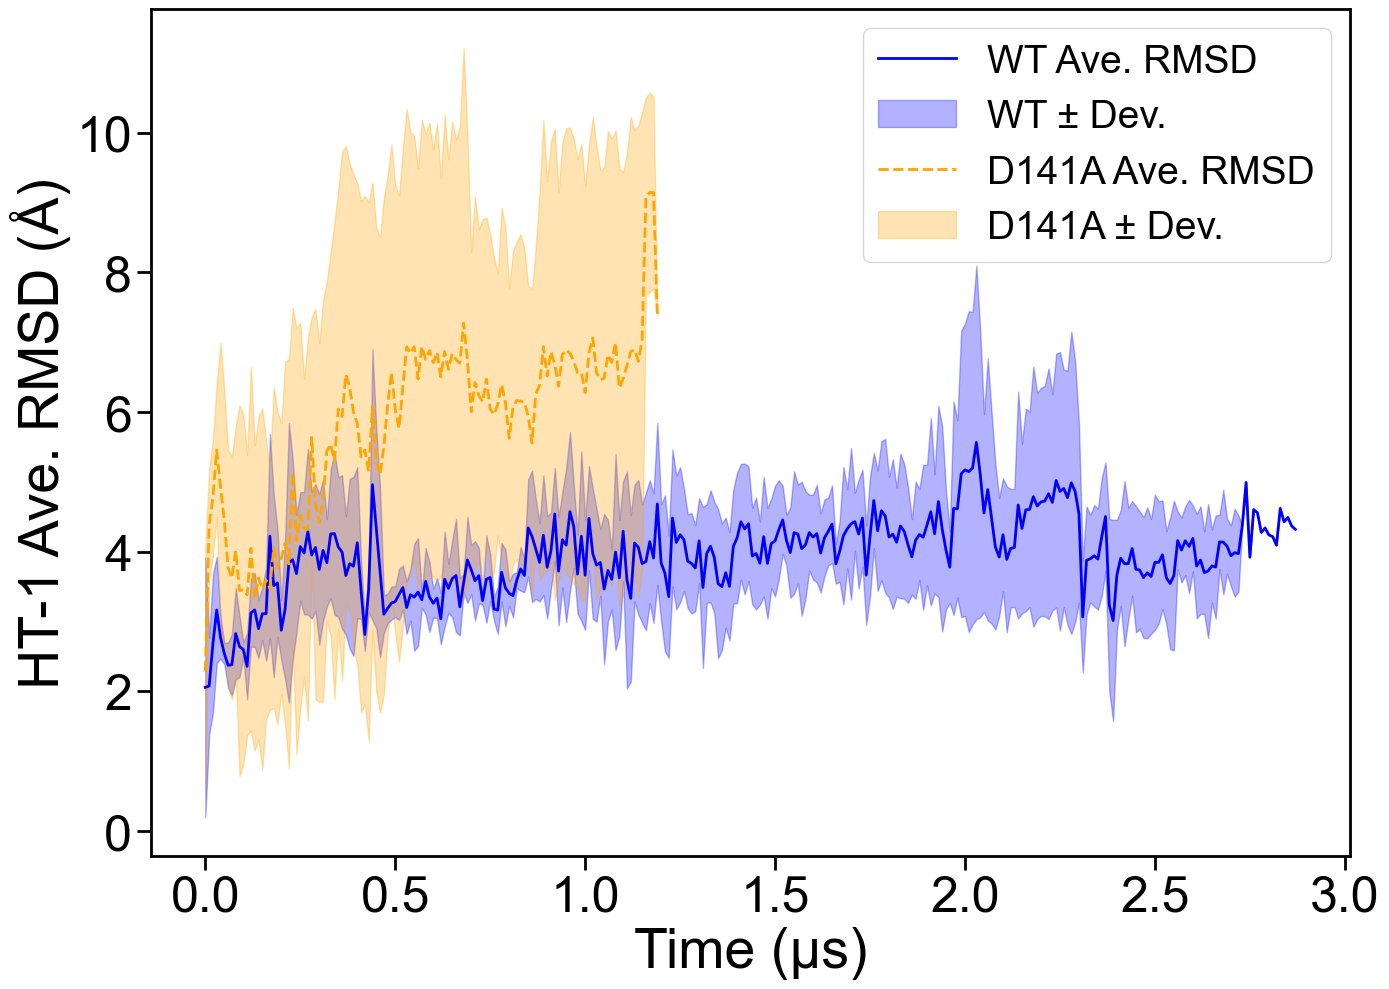

In [80]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
from matplotlib import font_manager

# Save path for the new plot
save_path = "/Scr/yunsenz2/data/BmrCD/figure/HT1_RMSD_avg_plot.png"

# Scaling factor for x-axis
factor = 0.1

plt.figure(figsize=(14, 10))

# Plot WT Ave. RMSD with fill for standard Dev.
plt.plot(uniform_time * factor, wt_rmsd_mean, label="WT Ave. RMSD", color="blue", linewidth=2)
plt.fill_between(uniform_time * factor, 
                 wt_rmsd_mean - wt_rmsd_std, 
                 wt_rmsd_mean + wt_rmsd_std, 
                 color="blue", alpha=0.3, label="WT ± Dev.")

# Plot Mutant Ave.  RMSD with fill for standard Dev.
plt.plot(uniform_time * factor, mut_rmsd_mean, label="D141A Ave. RMSD", color="orange", linestyle='--', linewidth=2)
plt.fill_between(uniform_time * factor, 
                 mut_rmsd_mean - mut_rmsd_std, 
                 mut_rmsd_mean + mut_rmsd_std, 
                 color="orange", alpha=0.3, label="D141A ± Dev.")

# Add labels
plt.xlabel("Time (μs)", fontsize=40, fontname='Arial')
plt.ylabel("HT-1 Ave. RMSD (Å)", fontsize=40, fontname='Arial')
plt.xticks(fontsize=36, fontname='Arial')
plt.yticks(fontsize=36, fontname='Arial')

# Make the border thicker
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

def scale_x_ticks(x, pos):
    # Dynamically determine decimal places based on the scaling factor
    if factor < 1:
        return f"{x * factor:.1f}"  # Show 1 decimal place
    else:
        return f"{x * factor:.0f}"  # Show as integer

ax.xaxis.set_major_formatter(FuncFormatter(scale_x_ticks))

# Adjust tick parameters
ax.tick_params(axis='both', which='major', width=2, length=10)

# Add legend
legend_font = font_manager.FontProperties(family='Arial', size=28)
plt.legend(loc='upper right', fontsize=20, prop=legend_font, title_fontsize=28, frameon=True)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches='tight', format='png')
plt.show()


In [81]:
def compute_contacts_over_time(psf_file, dcd_file, cutoff=4.0, ligand_select="resid 3 and resname HT1", prot_select="protein"):
    """
    计算每帧中配体与蛋白质的原子接触数。
    
    参数：
    - psf_file (str): PSF 文件路径。
    - dcd_file (str): DCD 轨迹文件路径。
    - cutoff (float): 距离阈值（Å）。
    - ligand_select (str): 配体选择字符串。
    - prot_select (str): 蛋白质选择字符串。
    
    返回：
    - times (np.array): 时间数组。
    - contact_counts (np.array): 每帧的接触数数组。
    """
    u = mda.Universe(psf_file, dcd_file)
    ligand = u.select_atoms(ligand_select)
    protein = u.select_atoms(prot_select)
    
    times = []
    contact_counts = []
    
    for ts in u.trajectory[::5]:
        # 计算距离矩阵
        dists = distances.distance_array(ligand.positions, protein.positions)
        # 计算低于阈值的接触数
        n_contacts = np.sum(dists < cutoff)
        contact_counts.append(n_contacts)
        times.append(ts.time)
    
    return np.array(times), np.array(contact_counts)

# 初始化存储接触数数据
wt_contacts_list = []
mut_contacts_list = []

# 处理 WT 轨迹
for i, dcd in enumerate(wt_dcd_list, 1):
    try:
        print(f"正在处理 WT 复制 {i}: {dcd}")
        times, contacts = compute_contacts_over_time(wt_psf, dcd, cutoff=4.0, ligand_select="resid 3 and resname HT1", prot_select="protein")
        wt_contacts_list.append(contacts)
    except Exception as e:
        print(f"处理 WT 复制 {i} 时出错: {e}")

# 处理 Mutant 轨迹
for i, dcd in enumerate(mut_dcd_list, 1):
    try:
        print(f"正在处理 Mutant 复制 {i}: {dcd}")
        times, contacts = compute_contacts_over_time(mut_psf, dcd, cutoff=4.0, ligand_select="resid 3 and resname HT1", prot_select="protein")
        mut_contacts_list.append(contacts)
    except Exception as e:
        print(f"处理 Mutant 复制 {i} 时出错: {e}")

# 插值接触数数据到统一的时间网格
wt_contacts_interp = []
mut_contacts_interp = []

for contacts, times in zip(wt_contacts_list, wt_time_list):
    interp_func = interp1d(times, contacts, kind='linear', bounds_error=False, fill_value=np.nan)
    contacts_uniform = interp_func(uniform_time)
    wt_contacts_interp.append(contacts_uniform)
from tqdm.notebook import tqdm  

for contacts, times in zip(mut_contacts_list, mut_time_list):
    interp_func = interp1d(times, contacts, kind='linear', bounds_error=False, fill_value=np.nan)
    contacts_uniform = interp_func(uniform_time)
    mut_contacts_interp.append(contacts_uniform)

# 转换为 NumPy 数组
wt_contacts_interp = np.array(wt_contacts_interp)
mut_contacts_interp = np.array(mut_contacts_interp)

# 计算均值和标准差，忽略 NaN
wt_contacts_mean = np.nanmean(wt_contacts_interp, axis=0)
wt_contacts_std = np.nanstd(wt_contacts_interp, axis=0)

mut_contacts_mean = np.nanmean(mut_contacts_interp, axis=0)
mut_contacts_std = np.nanstd(mut_contacts_interp, axis=0)


正在处理 WT 复制 1: /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep1.dcd
正在处理 WT 复制 2: /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep2.dcd
正在处理 WT 复制 3: /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep4.dcd
正在处理 Mutant 复制 1: /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep1.dcd
正在处理 Mutant 复制 2: /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep2.dcd
正在处理 Mutant 复制 3: /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep3.dcd


/tmp/ipykernel_3565795/2435992399.py:75: RuntimeWarning: Mean of empty slice
  wt_contacts_mean = np.nanmean(wt_contacts_interp, axis=0)
/tmp/ipykernel_3565795/2435992399.py:78: RuntimeWarning: Mean of empty slice
  mut_contacts_mean = np.nanmean(mut_contacts_interp, axis=0)


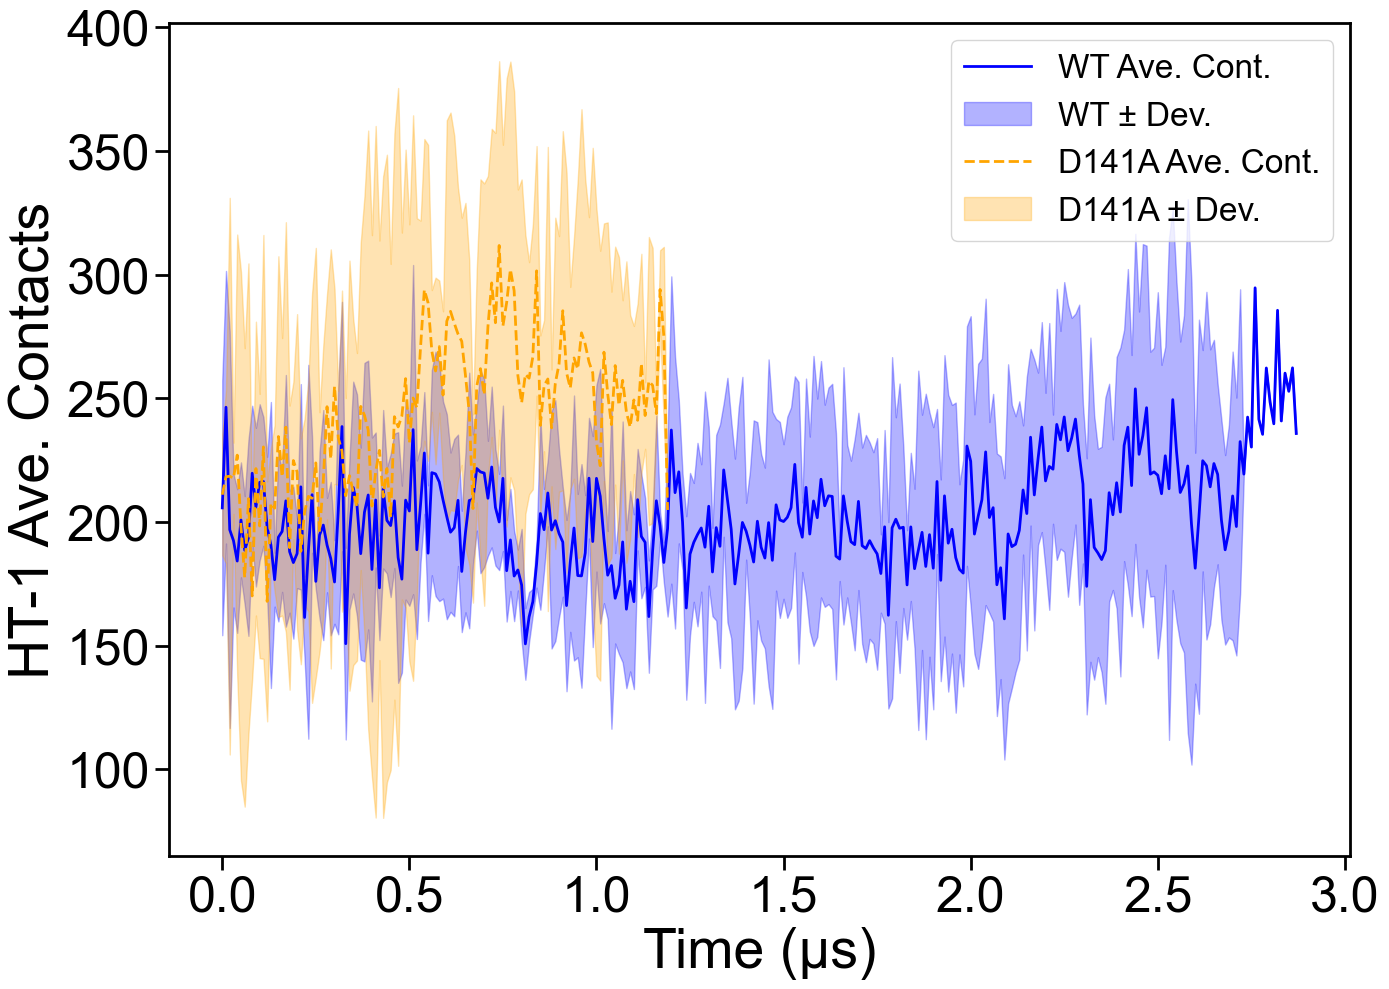

In [82]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import font_manager

# Save path for the plot
save_path = "/Scr/yunsenz2/data/BmrCD/figure/HT1_Contacts_plot.png"

# Scaling factor for x-axis
factor = 0.1  # Convert time units

plt.figure(figsize=(14, 10))

# Plot WT Ave.  contact number with fill for standard Dev.
plt.plot(uniform_time * factor, wt_contacts_mean, label="WT Ave. Cont.", color="blue", linewidth=2)
plt.fill_between(uniform_time * factor, 
                 wt_contacts_mean - wt_contacts_std, 
                 wt_contacts_mean + wt_contacts_std, 
                 color="blue", alpha=0.3, label="WT ± Dev.")

# Plot Mutant Ave.  contact number with fill for standard Dev.
plt.plot(uniform_time * factor, mut_contacts_mean, label="D141A Ave. Cont.", color="orange", linestyle='--', linewidth=2)
plt.fill_between(uniform_time * factor, 
                 mut_contacts_mean - mut_contacts_std, 
                 mut_contacts_mean + mut_contacts_std, 
                 color="orange", alpha=0.3, label="D141A ± Dev.")

# Add labels
plt.xlabel("Time (μs)", fontsize=40, fontname='Arial')
plt.ylabel("HT-1 Ave. Contacts", fontsize=40, fontname='Arial')
plt.xticks(fontsize=36, fontname='Arial')
plt.yticks(fontsize=36, fontname='Arial')

# Make the border thicker
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Add custom x-axis tick formatter
def scale_x_ticks(x, pos):
    # Dynamically determine decimal places based on the scaling factor
    if factor < 1:
        return f"{x * factor:.1f}"  # Show 1 decimal place
    else:
        return f"{x * factor:.0f}"  # Show as integer

ax.xaxis.set_major_formatter(FuncFormatter(scale_x_ticks))

# Adjust tick parameters
ax.tick_params(axis='both', which='major', width=2, length=10)

# Add legend
legend_font = font_manager.FontProperties(family='Arial', size=24)
plt.legend(loc='upper right', fontsize=20, prop=legend_font, title_fontsize=24, frameon=True)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches='tight', format='png')
plt.show()



In [83]:
from tqdm.notebook import tqdm  
# 定义一个函数来计算每帧的接触数
def calculate_contacts_per_frame(psf_file, dcd_files, ligand_name="resid 3 and resname HT1", cutoff=5.0):
    """
    计算指定配体与蛋白质之间每帧的接触数目。

    Parameters:
    - psf_file (str): PSF 文件路径。
    - dcd_files (list of str): DCD 文件路径列表。
    - ligand_name (str): 配体的名称。
    - cutoff (float): 接触距离阈值（埃）。

    Returns:
    - contacts_dict (dict): 轨迹文件名作为键，每个键对应一个包含每帧接触数的列表。
    - max_frames (int): 所有轨迹中最大的帧数。
    """
    contacts_dict = {}
    max_frames = 0

    for dcd in tqdm(dcd_files, desc=f"Processing {psf_file}"):
        # 加载轨迹
        u = mda.Universe(psf_file, dcd)

        # 选择配体和蛋白质
        ligand = u.select_atoms(ligand_name)
        protein = u.select_atoms("protein")

        # 初始化每帧接触计数列表
        frame_contacts = []

        # 遍历每一帧
        for ts in u.trajectory:
            # 使用 distance_array 计算距离
            distances = mda.lib.distances.distance_array(ligand.positions, protein.positions)
            # 统计小于 cutoff 的距离
            contacts = np.sum(distances < cutoff)
            frame_contacts.append(contacts)

        # 更新最大帧数
        if len(frame_contacts) > max_frames:
            max_frames = len(frame_contacts)

        # 存储每帧接触数
        trajectory_name = dcd.split("/")[-1]  # 使用文件名作为键
        contacts_dict[trajectory_name] = frame_contacts

    return contacts_dict, max_frames

# 定义一个函数来对每个轨迹的接触数进行填充，使其长度一致
def pad_contacts(contacts_dict, max_length):
    """
    对每个轨迹的接触数列表进行填充，使其长度一致。

    Parameters:
    - contacts_dict (dict): 轨迹文件名作为键，每个键对应一个包含每帧接触数的列表。
    - max_length (int): 填充后的最大帧数。

    Returns:
    - padded_df (DataFrame): 填充后的接触数数据框，轨迹作为列，帧数作为行。
    """
    padded_data = {}
    for traj, contacts in contacts_dict.items():
        # 如果轨迹长度不足，使用 NaN 填充
        if len(contacts) < max_length:
            padded_contacts = contacts + [np.nan]*(max_length - len(contacts))
        else:
            padded_contacts = contacts
        padded_data[traj] = padded_contacts
    return pd.DataFrame(padded_data)

# 计算 WT 和 Mut 的每帧接触数
wt_contacts_dict, wt_max_frames = calculate_contacts_per_frame(wt_psf, wt_dcd_list, ligand_name="resid 3 and resname HT1", cutoff=5.0)
mut_contacts_dict, mut_max_frames = calculate_contacts_per_frame(mut_psf, mut_dcd_list, ligand_name="resid 3 and resname HT1", cutoff=5.0)

# 确定总体最大的帧数
overall_max_frames = max(wt_max_frames, mut_max_frames)

# 对 WT 和 Mut 的数据进行填充
wt_padded_df = pad_contacts(wt_contacts_dict, overall_max_frames)
mut_padded_df = pad_contacts(mut_contacts_dict, overall_max_frames)

# 计算 WT 和 Mut 的每帧接触数
#wt_contacts_dict, wt_max_frames = calculate_contacts_per_frame(wt_psf, wt_dcd_list, ligand_name="resid 3 and resname HT1", cutoff=5.0)
#mut_contacts_dict, mut_max_frames = calculate_contacts_per_frame(mut_psf, mut_dcd_list, ligand_name="resid 3 and resname HT1", cutoff=5.0)

# 确定总体最大的帧数
#overall_max_frames = max(wt_max_frames, mut_max_frames)

Processing /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep1.psf:   0%|          | 0/3 [00:00<?, ?it/s]

Processing /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep1.psf:   0%|          | 0/3 [00:00<?, ?it/s]

In [84]:
# 确定统一的时间网格
# 找到所有复制的最大时间
all_times = np.concatenate(wt_time_list + mut_time_list)
min_time = all_times.min()
max_time = all_times.max()
time_step = 1.0  # 1 ps 时间步长

uniform_time = np.arange(min_time, max_time + time_step, time_step)

# 初始化列表存储插值后的 RMSD
wt_rmsd_interp = []
mut_rmsd_interp = []

# 插值 WT RMSD 数据
for times, rmsd in zip(wt_time_list, wt_rmsd_list):
    # 创建插值函数
    interp_func = interp1d(times, rmsd, kind='linear', bounds_error=False, fill_value=np.nan)
    # 计算插值 RMSD
    rmsd_uniform = interp_func(uniform_time)
    wt_rmsd_interp.append(rmsd_uniform)

# 插值 Mutant RMSD 数据
for times, rmsd in zip(mut_time_list, mut_rmsd_list):
    # 创建插值函数
    interp_func = interp1d(times, rmsd, kind='linear', bounds_error=False, fill_value=np.nan)
    # 计算插值 RMSD
    rmsd_uniform = interp_func(uniform_time)
    mut_rmsd_interp.append(rmsd_uniform)


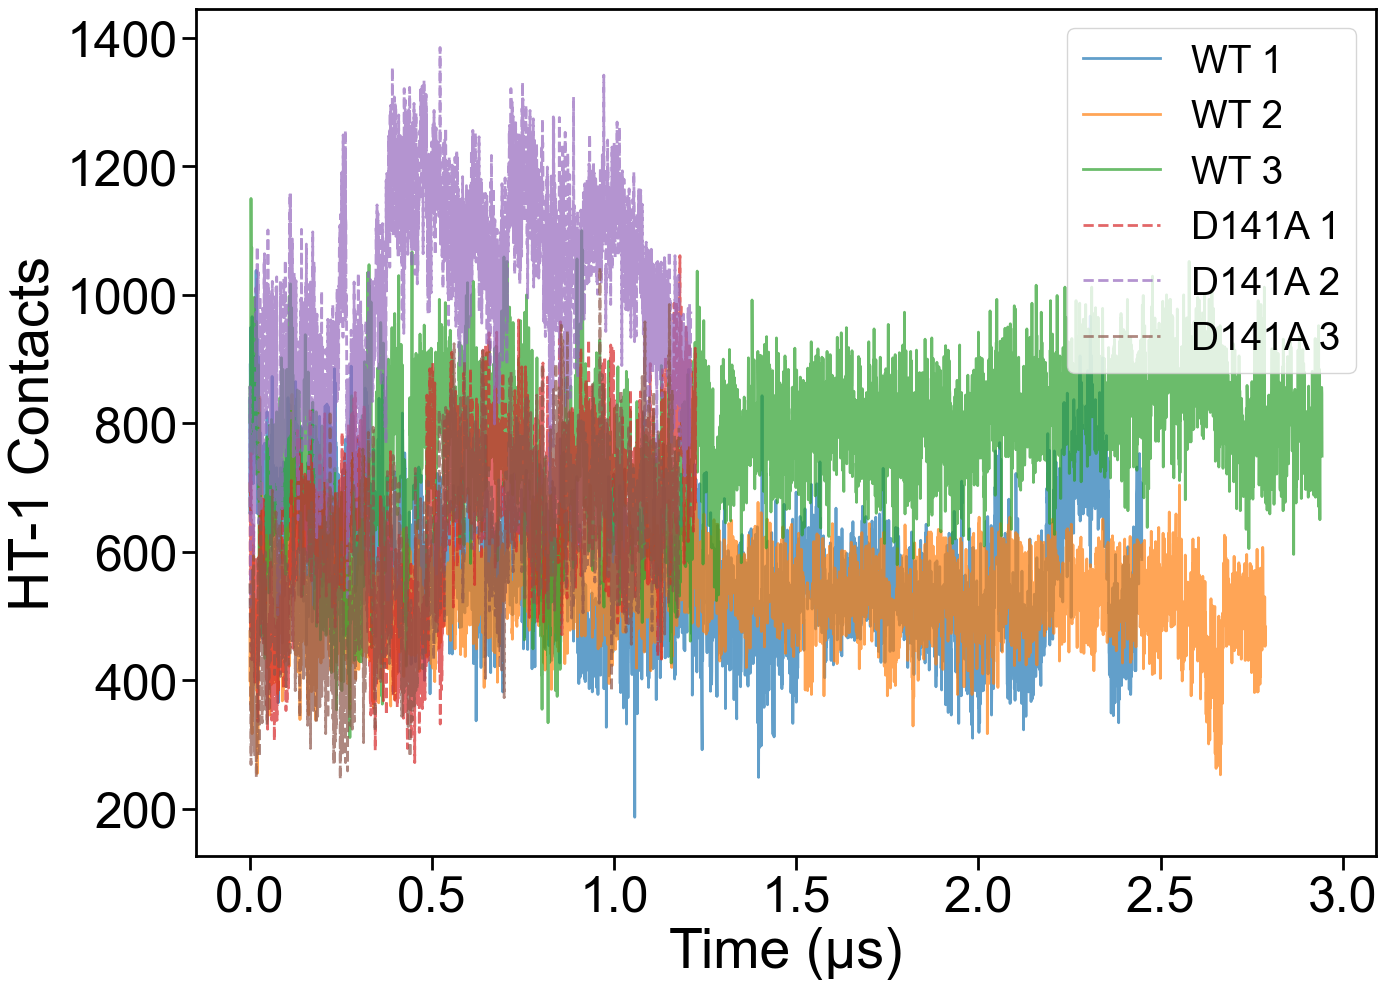

In [85]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
from matplotlib import font_manager
wt_padded_df = pad_contacts(wt_contacts_dict, overall_max_frames)
mut_padded_df = pad_contacts(mut_contacts_dict, overall_max_frames)
def plot_contacts(wt_df, mut_df, max_frames, factor=0.1, save_path=None):
    """
    绘制 WT 和 Mut 的接触数随时间变化的图，符合特定的可视化风格。

    Parameters:
    - wt_df (DataFrame): WT 的接触数数据框。
    - mut_df (DataFrame): Mut 的接触数数据框。
    - max_frames (int): 最大帧数，用于设置 x 轴。
    - factor (float): x 轴缩放因子，用于时间单位转换。
    - save_path (str): 如果提供路径，则将图保存为高分辨率图片。
    """
    plt.figure(figsize=(14, 10))

    # 生成 x 轴帧数
    x = np.arange(max_frames) * factor  # Apply scaling factor to x-axis

    # Plot WT replicas
    for i, column in enumerate(wt_df.columns, 1):
        plt.plot(x, wt_df[column], label=f"WT {i}", alpha=0.7, linewidth=2)

    # Plot Mut replicas
    for i, column in enumerate(mut_df.columns, 1):
        plt.plot(x, mut_df[column], label=f"D141A {i}", alpha=0.7, linestyle='--', linewidth=2)

    # Add labels
    plt.xlabel("Time (μs)", fontsize=40, fontname='Arial')
    plt.ylabel("HT-1 Contacts", fontsize=40, fontname='Arial')
    plt.xticks(fontsize=36, fontname='Arial')
    plt.yticks(fontsize=36, fontname='Arial')

    # Make the border thicker
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(2)

    # Add custom x-axis tick formatter
    def scale_x_ticks(x, pos):
        if factor < 1:
            return f"{x:.1f}"  # Show 1 decimal place for scaled time
        return f"{x:.0f}"  # Show as integer

    ax.xaxis.set_major_formatter(FuncFormatter(scale_x_ticks))

    # Adjust tick parameters
    ax.tick_params(axis='both', which='major', width=2, length=10)

    # Add legend
    legend_font = font_manager.FontProperties(family='Arial', size=28)
    plt.legend(loc='upper right', fontsize=20, prop=legend_font, title_fontsize=28, frameon=True)

    # Add grid
#    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Adjust layout
    plt.tight_layout()

    # Save figure if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', format='png')

    # Show plot
    plt.show()

# Example usage
plot_contacts(wt_padded_df, mut_padded_df, overall_max_frames, factor=0.0005, save_path="/Scr/yunsenz2/data/BmrCD/figure/HT1_Each_Contacts_plot.png")


开始处理 WT 轨迹: /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep1.dcd
预选择蛋白质原子数量: 511 个原子。
Processing /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep1.dcd - Frame: 0, Time: 0.0
Processing /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep1.dcd - Frame: 1, Time: 2.0
Processing /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep1.dcd - Frame: 2, Time: 4.0
Processing /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep1.dcd - Frame: 3, Time: 6.0
Processing /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep1.dcd - Frame: 4, Time: 8.0
开始处理 WT 轨迹: /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep2.dcd


/Scr/yunsenz2/data/software/miniconda3/envs/mdanalysis/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


预选择蛋白质原子数量: 546 个原子。
Processing /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep2.dcd - Frame: 0, Time: 0.0
Processing /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep2.dcd - Frame: 1, Time: 2.0
Processing /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep2.dcd - Frame: 2, Time: 4.0
Processing /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep2.dcd - Frame: 3, Time: 6.0
Processing /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep2.dcd - Frame: 4, Time: 8.0
开始处理 WT 轨迹: /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep4.dcd


/Scr/yunsenz2/data/software/miniconda3/envs/mdanalysis/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


预选择蛋白质原子数量: 584 个原子。
Processing /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep4.dcd - Frame: 0, Time: 0.0
Processing /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep4.dcd - Frame: 1, Time: 2.0
Processing /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep4.dcd - Frame: 2, Time: 4.0
Processing /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep4.dcd - Frame: 3, Time: 6.0
Processing /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep4.dcd - Frame: 4, Time: 8.0
WT 合并后的 DataFrame 形状: (199517, 6)
开始处理 Mutant 轨迹: /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep1.dcd


/Scr/yunsenz2/data/software/miniconda3/envs/mdanalysis/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


预选择蛋白质原子数量: 502 个原子。
Processing /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep1.dcd - Frame: 0, Time: 0.0
Processing /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep1.dcd - Frame: 1, Time: 2.0
Processing /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep1.dcd - Frame: 2, Time: 4.0
Processing /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep1.dcd - Frame: 3, Time: 6.0
Processing /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep1.dcd - Frame: 4, Time: 8.0
开始处理 Mutant 轨迹: /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep2.dcd


/Scr/yunsenz2/data/software/miniconda3/envs/mdanalysis/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


预选择蛋白质原子数量: 472 个原子。
Processing /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep2.dcd - Frame: 0, Time: 0.0
Processing /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep2.dcd - Frame: 1, Time: 2.0
Processing /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep2.dcd - Frame: 2, Time: 4.0
Processing /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep2.dcd - Frame: 3, Time: 6.0
Processing /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep2.dcd - Frame: 4, Time: 8.0
开始处理 Mutant 轨迹: /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep3.dcd


/Scr/yunsenz2/data/software/miniconda3/envs/mdanalysis/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


预选择蛋白质原子数量: 463 个原子。
Processing /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep3.dcd - Frame: 0, Time: 0.0
Processing /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep3.dcd - Frame: 1, Time: 2.0
Processing /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep3.dcd - Frame: 2, Time: 4.0
Processing /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep3.dcd - Frame: 3, Time: 6.0
Processing /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep3.dcd - Frame: 4, Time: 8.0
Mutant 合并后的 DataFrame 形状: (73385, 6)
所有数据合并后的 DataFrame 形状: (272902, 6)
WT 最长时间: 11774.0
Mutant 最长时间: 4898.0
全局最长时间: 11774.0
所有数据的 'time' 列 NaN 数量: 0


/tmp/ipykernel_3565795/3506888444.py:216: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["contact_count"] = df["contact_count"].fillna(method=fill_method)
/tmp/ipykernel_3565795/3506888444.py:216: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["contact_count"] = df["contact_count"].fillna(method=fill_method)
/tmp/ipykernel_3565795/3506888444.py:216: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["contact_count"] = df["contact_count"].fillna(method=fill_method)
/tmp/ipykernel_3565795/3506888444.py:216: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["contact_count"] = df["contact_count"].fillna(method=fill_method)
/tmp/ipykernel_3

插值后的 DataFrame 形状: (3179250, 5)
插值后的 'contact_count' 列 NaN 数量: 105358
   time residue_label  contact_count  system  \
0   0.0          A141           15.0  Mutant   
1   1.0          A141           14.0  Mutant   
2   2.0          A141           13.0  Mutant   
3   3.0          A141            7.0  Mutant   
4   4.0          A141            1.0  Mutant   

                                           traj_file  
0  /Scr/msincla01/BmrCD/of-state/analysis/trajs/d...  
1  /Scr/msincla01/BmrCD/of-state/analysis/trajs/d...  
2  /Scr/msincla01/BmrCD/of-state/analysis/trajs/d...  
3  /Scr/msincla01/BmrCD/of-state/analysis/trajs/d...  
4  /Scr/msincla01/BmrCD/of-state/analysis/trajs/d...  
PSF 文件解析结果 (前5行):


/Scr/yunsenz2/data/software/miniconda3/envs/mdanalysis/lib/python3.12/site-packages/MDAnalysis/core/universe.py:150: UserWarning: No coordinate reader found for /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep1.psf. Skipping this file.
  warnings.warn('No coordinate reader found for {}. Skipping '


,residue_label,Chain
0,F2,C
1,S3,C
2,V4,C
3,L5,C
4,K6,C


匹配到链信息的残基数: 3143925
总残基数: 3179250
匹配率: 98.89%
警告: 有 35325 个残基未匹配到链信息, 填充为Unknown。
df_merged.head():


,time,residue_label,contact_count,system,traj_file,Chain
0,0.0,A141,15.0,Mutant,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,Unknown
1,1.0,A141,14.0,Mutant,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,Unknown
2,2.0,A141,13.0,Mutant,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,Unknown
3,3.0,A141,7.0,Mutant,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,Unknown
4,4.0,A141,1.0,Mutant,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,Unknown
5,5.0,A141,1.0,Mutant,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,Unknown
6,6.0,A141,1.0,Mutant,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,Unknown
7,7.0,A141,1.0,Mutant,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,Unknown
8,8.0,A141,1.0,Mutant,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,Unknown
9,9.0,A141,1.0,Mutant,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,Unknown


合并并替换后，链ID汇总:
Chain
BmrC       2249025
BmrD        894900
Unknown      35325
Name: count, dtype: int64
Unique systems after replacement: ['D141A' 'WT']
符合阈值的残基数: 5
plot_data 行数: 353250


,time,residue_label,contact_count,system,traj_file,Chain
35325,0.0,E33,NaN,D141A,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,BmrC
35326,1.0,E33,NaN,D141A,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,BmrC
35327,2.0,E33,12.000000,D141A,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,BmrC
35328,3.0,E33,11.951389,D141A,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,BmrC
35329,4.0,E33,11.902778,D141A,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,BmrC
35330,5.0,E33,11.854167,D141A,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,BmrC
35331,6.0,E33,11.805556,D141A,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,BmrC
35332,7.0,E33,11.756944,D141A,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,BmrC
35333,8.0,E33,11.708333,D141A,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,BmrC
35334,9.0,E33,11.659722,D141A,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,BmrC


BmrC 残基数: 5
BmrD 残基数: 0


/tmp/ipykernel_3565795/3506888444.py:453: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


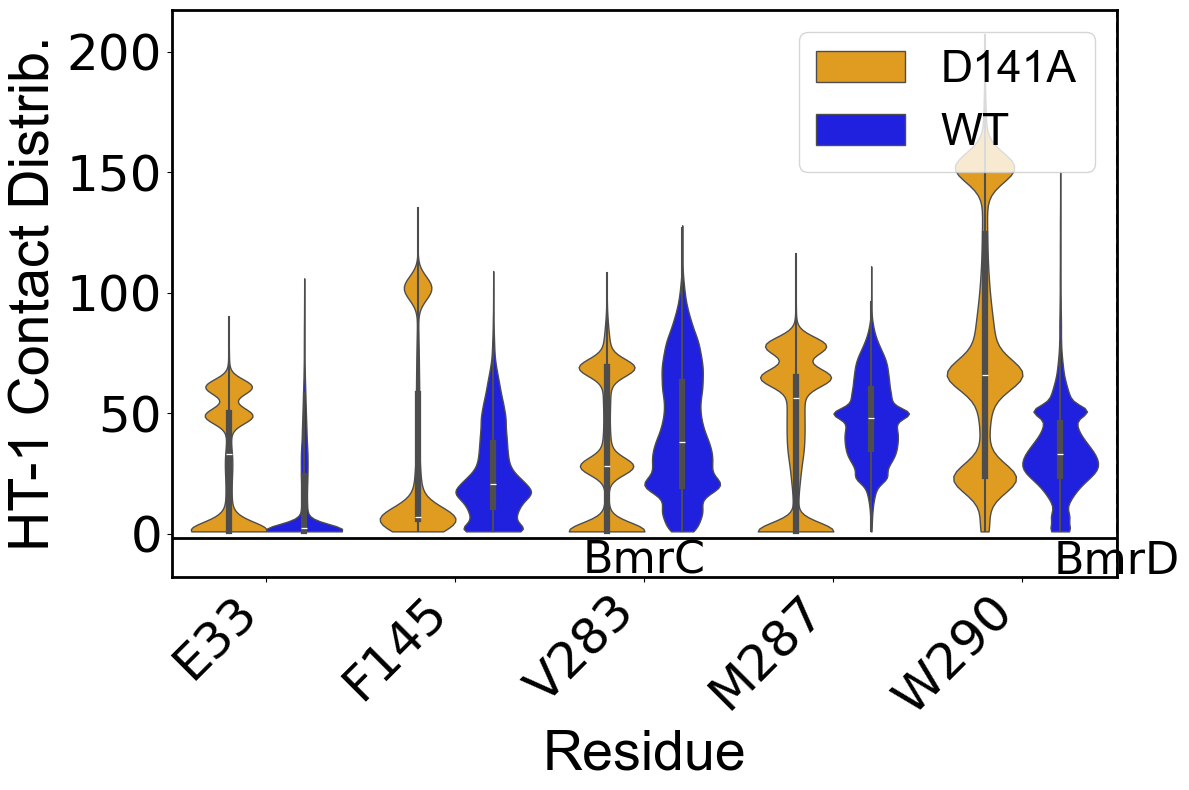


链 BmrC 包含以下残基:
E33, F145, V283, M287, W290


In [86]:
import pandas as pd
import numpy as np
import MDAnalysis as mda
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# 定义三字母到单字母氨基酸代码的映射
three_to_one_map = {
    "ALA": "A", "CYS": "C", "ASP": "D", "GLU": "E", "PHE": "F", "GLY": "G",
    "HIS": "H", "ILE": "I", "LYS": "K", "LEU": "L", "MET": "M", "ASN": "N",
    "PRO": "P", "GLN": "Q", "ARG": "R", "SER": "S", "THR": "T", "VAL": "V",
    "TRP": "W", "TYR": "Y", "HSD": "H", "HIE": "H", "HIP": "H", "CYX": "C",
    "GLH": "E", "ASH": "D", "LYN": "K", "HID": "H"
}

def three_to_one(residue_name):
    """
    将三字母氨基酸代码转换为单字母代码。
    如果三字母代码未在映射中找到，则返回原始代码。
    """
    return three_to_one_map.get(residue_name.upper(), residue_name)

def load_single_trajectory(psf_file, dcd_file):
    """
    载入单条PSF+DCD轨迹，返回 Universe 对象。
    """
    u = mda.Universe(psf_file, dcd_file)
    return u

def preselect_protein_near_ligand(u, ligand_sel="resid 3 and resname HT1", initial_cutoff=8.0):
    """
    在初始帧上预选择与配体在 initial_cutoff 范围内的蛋白质原子。
    这样后续的接触计算只针对这些原子，提升效率。
    """
    ligand = u.select_atoms(ligand_sel)
    if len(ligand) == 0:
        print("警告：未找到配体原子，请检查选择器。")
        return mda.AtomGroup([])
    
    # 移动到初始帧
    u.trajectory[0]
    
    # 选择蛋白质原子
    protein = u.select_atoms("protein")
    
    # 计算距离矩阵
    distances = mda.lib.distances.distance_array(ligand.positions, protein.positions)
    
    # 对蛋白质原子取最小距离
    min_distances = distances.min(axis=0)
    
    # 选择距离小于 initial_cutoff 的蛋白质原子
    protein_near_ligand = protein[min_distances < initial_cutoff]
    
    print(f"预选择蛋白质原子数量: {len(protein_near_ligand)} 个原子。")
    return protein_near_ligand

def compute_contact_timeseries_optimized(psf_file, dcd_file, ligand_sel="resid 3 and resname HT1", protein_sel="protein", cutoff=4.5, initial_cutoff=8.0, dt=2.0):
    """
    优化后的函数，计算配体与蛋白质预选原子的接触时间序列。
    使用预选择和 distance_array 进行高效距离计算。
    """
    u = load_single_trajectory(psf_file, dcd_file)
    ligand_atoms = u.select_atoms(ligand_sel)
    
    if len(ligand_atoms) == 0:
        print(f"警告：在文件 {dcd_file} 中未找到配体原子，跳过该轨迹。")
        return pd.DataFrame(columns=["frame", "time", "residue_label", "contact_count"])
    
    # 预选择与配体接近的蛋白质原子
    protein_near_ligand = preselect_protein_near_ligand(u, ligand_sel=ligand_sel, initial_cutoff=initial_cutoff)
    
    if len(protein_near_ligand) == 0:
        print(f"警告：在文件 {dcd_file} 中未找到与配体接近的蛋白质原子，跳过该轨迹。")
        return pd.DataFrame(columns=["frame", "time", "residue_label", "contact_count"])
    
    records = []
    
    for ts in u.trajectory:
        frame_index = ts.frame
        current_time = frame_index * dt  # 手动计算时间
        
        # 打印前几帧的时间，确认
        if frame_index < 5:
            print(f"Processing {dcd_file} - Frame: {frame_index}, Time: {current_time}")
        
        # 计算距离矩阵
        dist_array = mda.lib.distances.distance_array(ligand_atoms.positions, protein_near_ligand.positions)
        contact_matrix = (dist_array < cutoff)
        
        residue_count = defaultdict(int)
        
        # 遍历 contact_matrix
        for i in range(contact_matrix.shape[0]):
            for j in range(contact_matrix.shape[1]):
                if contact_matrix[i, j]:
                    pro_atom = protein_near_ligand[j]
                    key = (pro_atom.resname, pro_atom.resid)
                    residue_count[key] += 1
        
        # 将每个残基的接触数记录下来，使用单字母代码
        for (resname, resid), cnt in residue_count.items():
            res_label = f"{three_to_one(resname)}{resid}"  # 使用单字母代码
            records.append((frame_index, current_time, res_label, cnt))
    
    # 转换为 DataFrame
    df = pd.DataFrame(records, columns=["frame", "time", "residue_label", "contact_count"])
    return df

# 文件路径
wt_psf = "/Scr/msincla01/BmrCD/of-state/analysis/trajs/rep1.psf"
wt_dcd_list = [
    "/Scr/msincla01/BmrCD/of-state/analysis/trajs/rep1.dcd",
    "/Scr/msincla01/BmrCD/of-state/analysis/trajs/rep2.dcd",
    "/Scr/msincla01/BmrCD/of-state/analysis/trajs/rep4.dcd"
]

mut_psf = "/Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep1.psf"
mut_dcd_list = [
    "/Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep1.dcd",
    "/Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep2.dcd",
    "/Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep3.dcd"
]

# 处理 WT
df_wt_list = []
for dcd_file in wt_dcd_list:
    print(f"开始处理 WT 轨迹: {dcd_file}")
    df_wt_contact = compute_contact_timeseries_optimized(
        wt_psf, 
        dcd_file, 
        ligand_sel="resid 3 and resname HT1", 
        protein_sel="protein", 
        cutoff=4.5, 
        initial_cutoff=8.0,  # 预选择的距离
        dt=2.0
    )
    if not df_wt_contact.empty:
        df_wt_contact["system"] = "WT"
        df_wt_contact["traj_file"] = dcd_file
        df_wt_list.append(df_wt_contact)

# 合并 WT 数据
df_wt_combined = pd.concat(df_wt_list, ignore_index=True) if df_wt_list else pd.DataFrame()
print(f"WT 合并后的 DataFrame 形状: {df_wt_combined.shape}")

# 处理 Mutant
df_mut_list = []
for dcd_file in mut_dcd_list:
    print(f"开始处理 Mutant 轨迹: {dcd_file}")
    df_mut_contact = compute_contact_timeseries_optimized(
        mut_psf, 
        dcd_file, 
        ligand_sel="resid 3 and resname HT1", 
        protein_sel="protein", 
        cutoff=4.5, 
        initial_cutoff=8.0,  # 预选择的距离
        dt=2.0
    )
    if not df_mut_contact.empty:
        df_mut_contact["system"] = "Mutant"
        df_mut_contact["traj_file"] = dcd_file
        df_mut_list.append(df_mut_contact)

# 合并 Mutant 数据
df_mut_combined = pd.concat(df_mut_list, ignore_index=True) if df_mut_list else pd.DataFrame()
print(f"Mutant 合并后的 DataFrame 形状: {df_mut_combined.shape}")

# 合并所有数据
df_all = pd.concat([df_wt_combined, df_mut_combined], ignore_index=True) if not df_wt_combined.empty or not df_mut_combined.empty else pd.DataFrame()
print(f"所有数据合并后的 DataFrame 形状: {df_all.shape}")

# 检查 'time' 列
if not df_all.empty:
    print("WT 最长时间:", df_wt_combined["time"].max() if not df_wt_combined.empty else "No data")
    print("Mutant 最长时间:", df_mut_combined["time"].max() if not df_mut_combined.empty else "No data")
    global_max_time = max(
        df_wt_combined["time"].max() if not df_wt_combined.empty else 0,
        df_mut_combined["time"].max() if not df_mut_combined.empty else 0
    )
    print("全局最长时间:", global_max_time)
else:
    print("警告：所有轨迹的合并数据为空。")
    global_max_time = 0

# 确认没有 NaN
if not df_all.empty:
    print("所有数据的 'time' 列 NaN 数量:", df_all['time'].isna().sum())
    # 删除 'frame' 列，因为在插值过程中它会产生 NaN
    df_all = df_all.drop(columns=["frame"], errors='ignore')
else:
    print("警告：df_all 为空，跳过插值。")

# 生成统一时间轴
if global_max_time > 0:
    new_time_spacing = 1.0  # 每 1 ps 插值
    new_time_points = np.arange(0, global_max_time + new_time_spacing, new_time_spacing)
else:
    new_time_points = np.array([])

def reindex_and_interpolate(df, new_time_points, fill_method="ffill"):
    """
    在统一时间轴上插值接触数目数据。
    """
    if df.empty:
        return pd.DataFrame(columns=["time", "contact_count", "residue_label", "system", "traj_file"])
    
    df = df.set_index("time").sort_index()
    # 合并原始时间点和新时间点，确保插值覆盖
    combined_time = np.union1d(df.index.values, new_time_points)
    df = df.reindex(combined_time).sort_index()
    df["contact_count"] = df["contact_count"].interpolate(method="linear")
    
    if fill_method is not None:
        df["contact_count"] = df["contact_count"].fillna(method=fill_method)
    return df.reindex(new_time_points).reset_index().rename(columns={"index": "time"})

# 插值
interp_results = []
group_cols = ["system", "traj_file", "residue_label"]
for key, sub_df in df_all.groupby(group_cols):
    tmp = reindex_and_interpolate(sub_df.copy(), new_time_points, fill_method="ffill")
    tmp["system"], tmp["traj_file"], tmp["residue_label"] = key
    interp_results.append(tmp)

df_interpolated = pd.concat(interp_results, ignore_index=True) if interp_results else pd.DataFrame()
print(f"插值后的 DataFrame 形状: {df_interpolated.shape}")

# 检查插值后的 DataFrame
if not df_interpolated.empty:
    print("插值后的 'contact_count' 列 NaN 数量:", df_interpolated['contact_count'].isna().sum())
    print(df_interpolated.head())
else:
    print("警告：插值后的 DataFrame 为空。")
import pandas as pd
import MDAnalysis as mda
from MDAnalysis.lib import transformations
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager

import matplotlib.path as mpath
import matplotlib.patches as mpatches

# -------------------------------
# 1) 定义三字母到单字母氨基酸代码的映射
# -------------------------------
three_to_one_map = {
    "ALA": "A", "CYS": "C", "ASP": "D", "GLU": "E", "PHE": "F", "GLY": "G",
    "HIS": "H", "ILE": "I", "LYS": "K", "LEU": "L", "MET": "M", "ASN": "N",
    "PRO": "P", "GLN": "Q", "ARG": "R", "SER": "S", "THR": "T", "VAL": "V",
    "TRP": "W", "TYR": "Y", "HSD": "H", "HIE": "H", "HIP": "H", "CYX": "C",
    "GLH": "E", "ASH": "D", "LYN": "K", "HID": "H"
}

def three_to_one(residue_name):
    """
    将三字母氨基酸代码转换为单字母代码。
    如果三字母代码未在映射中找到，则返回原始代码。
    """
    return three_to_one_map.get(residue_name.upper(), residue_name)

# -------------------------------
# 2) 解析 PSF 文件，提取 chain 和残基编号
# -------------------------------
def parse_psf_chain_residues(psf_path):
    """
    使用 MDAnalysis 解析 PSF 文件以提取链和残基编号信息。
    返回一个包含 [residue_label, Chain] 的DataFrame。
    """
    try:
        u = mda.Universe(psf_path)
    except Exception as e:
        print(f"无法解析 PSF 文件: {e}")
        return None
    
    data = []
    for res in u.residues:
        chain_id = res.segid.strip() if res.segid.strip() else "Unknown"
        res_num = res.resid
        res_name = three_to_one(res.resname)
        
        data.append({
            'residue_label': f"{res_name}{res_num}",
            'Chain': chain_id
        })
    
    df_psf = pd.DataFrame(data)
    df_psf.drop_duplicates(subset=['residue_label'], inplace=True)
    df_psf.reset_index(drop=True, inplace=True)
    
    return df_psf

# -------------------------------
# 3) 自定义函数: 绘制水平花括号 (brace)
# -------------------------------
def draw_curly_brace(ax, xstart, xend, y, text="", color='k', lw=2, fontsize=16):
    """
    在 (xstart -> xend) 范围内、以 y 为中心，绘制一个近似的水平花括号，并在其下方居中写上 text。
    这是用 Bezier 曲线画的简易形状，clip_on=False 以便超出坐标轴可见。
    """
    length = xend - xstart
    if length < 0:
        length = -length
        xstart, xend = xend, xstart

    verts = [
        (0.0, 0.5),  # 起点：左上
        (0.0, 0.0),  # 直线向下：左下
        (1.0, 0.0),  # 横线向右
        (1.0, -0.5)  # 直线向下：右下
    ]
    codes = [
        mpath.Path.MOVETO,  # 移动到起点
        mpath.Path.LINETO,  # 画直线到左下
        mpath.Path.LINETO,  # 画横线到右
        mpath.Path.LINETO   # 画直线到右下
    ]


    # 在 x 方向缩放到 length，y 方向做一点微缩
    xscale = length
    yscale = 0.3
    transformed_verts = []
    for vx, vy in verts:
        tx = xstart + vx * xscale
        ty = y + vy * yscale
        transformed_verts.append((tx, ty))

    path = mpath.Path(transformed_verts, codes)
    patch = mpatches.PathPatch(path, fill=False, color=color, lw=lw, clip_on=False)
    ax.add_patch(patch)

    # 在花括号正下方居中写上文字，增加偏移量
    ax.text(
        xstart + xscale/2,
        y - 0.6,  # 增加偏移量
        text,
        ha='center',
        va='top',
        fontsize=fontsize,
        color=color,
        clip_on=False
    )

# -------------------------------
# 4) 指定 PSF 文件路径并解析
# -------------------------------
psf_path = "/Scr/msincla01/BmrCD/of-state/analysis/trajs/rep1.psf"
df_psf = parse_psf_chain_residues(psf_path)

if df_psf is None:
    print("解析 PSF 文件失败。无法继续。")
else:
    print("PSF 文件解析结果 (前5行):")
    display(df_psf.head())

# -------------------------------
# 5) 获取或定义 df_interpolated
# -------------------------------
try:
    df_interpolated
except NameError:
    raise RuntimeError("数据框 'df_interpolated' 不存在。请确保第一段代码已正确运行并生成该数据框。")

# -------------------------------
# 6) 合并 df_interpolated 与 df_psf
# -------------------------------
if df_psf is not None and not df_interpolated.empty:
    df_merged = pd.merge(df_interpolated, df_psf, on='residue_label', how='left')
    
    # 统计匹配情况
    matched = df_merged['Chain'].notnull().sum()
    total = len(df_merged)
    print(f"匹配到链信息的残基数: {matched}")
    print(f"总残基数: {total}")
    print(f"匹配率: {matched / total * 100:.2f}%")
    
    # 无法匹配的先填充 Unknown
    missing = df_merged['Chain'].isnull().sum()
    if missing > 0:
        print(f"警告: 有 {missing} 个残基未匹配到链信息, 填充为Unknown。")
        df_merged['Chain'] = df_merged['Chain'].fillna("Unknown")
    
    print("df_merged.head():")
    display(df_merged.head(10))
    
    # 如果实际的链ID为 "C"/"D"，而我们想把它命名为 "BmrC"/"BmrD"
    chain_replace_dict = {"C": "BmrC", "D": "BmrD"}
    df_merged['Chain'] = df_merged['Chain'].replace(chain_replace_dict)
    
    print("合并并替换后，链ID汇总:")
    print(df_merged['Chain'].value_counts(dropna=False))
    
    # 替换 'Mutant' & 'MT' => 'D141A'
    df_merged["system"] = df_merged["system"].replace({"Mutant": "D141A", "MT": "D141A"})
    unique_systems = df_merged["system"].unique()
    print("Unique systems after replacement:", unique_systems)

    # 动态生成调色板
    unique_systems_sorted = sorted(unique_systems)
    palette_colors = sns.color_palette("husl", len(unique_systems_sorted))
    palette = {
        "D141A": "orange",  # 自定义颜色
        "WT": "blue"         # 自定义颜色
    }

    # -------------------------------
    # 7) 根据阈值筛选感兴趣残基
    # -------------------------------
    contact_threshold = 20  # 可根据需要调整阈值
    residues_of_interest = (
        df_merged.groupby("residue_label")["contact_count"]
        .mean()
        .loc[lambda x: x >= contact_threshold]
        .index.tolist()
    )
    
    print("符合阈值的残基数:", len(residues_of_interest))
    if len(residues_of_interest) < 1:
        print("Warning: 没有任何残基均值超过阈值，无法绘图。")
    else:
        plot_data = df_merged[df_merged["residue_label"].isin(residues_of_interest)].copy()
        print("plot_data 行数:", len(plot_data))
        display(plot_data.head(10))
        
        if 'Chain' not in plot_data.columns:
            print("错误: 'Chain' 列不存在于合并后的数据框中。")
        else:
            # -------------------------------
            # 8) 用 violinplot 单轴绘图
            # -------------------------------
            
            # 分别获取 BmrC / BmrD 的残基，并排序
            chainC = plot_data.loc[plot_data["Chain"]=="BmrC","residue_label"].unique().tolist()
            chainD = plot_data.loc[plot_data["Chain"]=="BmrD","residue_label"].unique().tolist()
            
            def residue_num(res):
                return int("".join(filter(str.isdigit, res)))  # 提取数字用于排序
            
            chainC_sorted = sorted(chainC, key=residue_num)
            chainD_sorted = sorted(chainD, key=residue_num)
            residue_order = chainC_sorted + chainD_sorted
            
            print("BmrC 残基数:", len(chainC_sorted))
            print("BmrD 残基数:", len(chainD_sorted))
            
            fig = plt.figure(figsize=(12, 8))
            ax = fig.add_subplot(111)
            
            # 如果只有2种 system, 想要镜像显示可加 split=True
            ax = sns.violinplot(
                data=plot_data,
                x="residue_label",
                y="contact_count",
                hue="system",
                order=residue_order,
                palette=palette,
                cut=0,
                scale="width",
                linewidth=1,
                # split=True,  # 若仅两种状态且想要镜像可开启
                ax=ax
            )
            
            # 中间分隔线（BmrC和BmrD的交界）
            plt.axvline(
                x=len(chainC_sorted)-0.5, 
                color='black', 
                linestyle='--', 
                linewidth=2
            )
            
            # 坐标轴 & 刻度
            ax.set_xlabel("Residue", fontsize=40, fontname='Arial')
            ax.set_ylabel("HT-1 Contact Distrib.", fontsize=40, fontname='Arial')
            ax.tick_params(axis='x', labelsize=36)
            ax.tick_params(axis='y', labelsize=36)
            plt.xticks(rotation=45, ha='right')
            
            # 加粗边框
            for spine in ax.spines.values():
                spine.set_linewidth(2)
            
            # 为了能在下方画花括号，我们手动稍微扩展一下下边距
            plt.subplots_adjust(bottom=0.35)
            
            # 先获取当前 y 轴范围
            y_min, y_max = ax.get_ylim()
            # 我们让下限进一步下移，如 -4
            new_ymin = min(y_min, -18)
            ax.set_ylim(new_ymin, y_max)
            
            # 关闭坐标轴的 clip 限制（或对patch设置 clip_on=False）即可让花括号超出坐标
            # draw_curly_brace: 在下方 y=-3.0 画BmrC / BmrD花括号
            x_left_brace_start = -0.5
            x_left_brace_end   = len(chainC_sorted)-0.5
            
            x_right_brace_start = len(chainC_sorted)-0.5
            x_right_brace_end   = len(chainC_sorted) + len(chainD_sorted) - 0.5
            
            brace_y = -1.8  # 下移至 -3.0
            
            # 画左侧花括号
            draw_curly_brace(
                ax, 
                xstart = x_left_brace_start, 
                xend   = x_left_brace_end, 
                y      = brace_y,
                text   = "BmrC",
                color  = 'black',
                lw     = 2,
                fontsize=32
            )
            
            # 画右侧花括号
            draw_curly_brace(
                ax, 
                xstart = x_right_brace_start, 
                xend   = x_right_brace_end, 
                y      = brace_y,
                text   = "BmrD",
                color  = 'black',
                lw     = 2,
                fontsize=32
            )
            
            # 图例
            legend_font = font_manager.FontProperties(family='Arial', size=32)
            ax.legend(
                # title="System",
                title_fontsize=32,
                prop=legend_font,
                loc='upper right',
                frameon=True
            )
            
            plt.tight_layout()
            
            save_path = "/Scr/yunsenz2/data/BmrCD/figure/HT1_contact_distribution.png"
            plt.savefig(save_path, dpi=300, bbox_inches='tight', format='png')
            plt.show()
            
            # -------------------------------
            # 9) 可选：打印每条链的残基
            # -------------------------------
            chain_dict = {}
            for index, row in plot_data.iterrows():
                ch = row['Chain']
                res = row['residue_label']
                if ch not in chain_dict:
                    chain_dict[ch] = set()
                chain_dict[ch].add(res)
            
            for ch, residues in chain_dict.items():
                sorted_res = sorted(residues, key=lambda x: int("".join(filter(str.isdigit, x))))
                print(f"\n链 {ch} 包含以下残基:")
                print(", ".join(sorted_res))
else:
    print("警告：合并后的数据框为空，无法进行后续操作。")


PSF 文件解析结果 (前5行):


/Scr/yunsenz2/data/software/miniconda3/envs/mdanalysis/lib/python3.12/site-packages/MDAnalysis/core/universe.py:150: UserWarning: No coordinate reader found for /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep1.psf. Skipping this file.
  warnings.warn('No coordinate reader found for {}. Skipping '


,residue_label,Chain
0,F2,C
1,S3,C
2,V4,C
3,L5,C
4,K6,C


警告: 有 35325 个残基未匹配到链信息, 填充为Unknown。
df_merged.head():


,time,residue_label,contact_count,system,traj_file,Chain
0,0.0,A141,15.0,Mutant,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,Unknown
1,1.0,A141,14.0,Mutant,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,Unknown
2,2.0,A141,13.0,Mutant,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,Unknown
3,3.0,A141,7.0,Mutant,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,Unknown
4,4.0,A141,1.0,Mutant,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,Unknown
5,5.0,A141,1.0,Mutant,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,Unknown
6,6.0,A141,1.0,Mutant,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,Unknown
7,7.0,A141,1.0,Mutant,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,Unknown
8,8.0,A141,1.0,Mutant,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,Unknown
9,9.0,A141,1.0,Mutant,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,Unknown


合并并替换后，链ID汇总:
Chain
BmrC       2249025
BmrD        894900
Unknown      35325
Name: count, dtype: int64
Unique systems after replacement: ['D141A' 'WT']
符合阈值的残基数: 7
plot_data 行数: 494550


,time,residue_label,contact_count,system,traj_file,Chain
35325,0.0,E33,NaN,D141A,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,BmrC
35326,1.0,E33,NaN,D141A,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,BmrC
35327,2.0,E33,12.000000,D141A,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,BmrC
35328,3.0,E33,11.951389,D141A,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,BmrC
35329,4.0,E33,11.902778,D141A,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,BmrC
35330,5.0,E33,11.854167,D141A,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,BmrC
35331,6.0,E33,11.805556,D141A,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,BmrC
35332,7.0,E33,11.756944,D141A,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,BmrC
35333,8.0,E33,11.708333,D141A,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,BmrC
35334,9.0,E33,11.659722,D141A,/Scr/msincla01/BmrCD/of-state/analysis/trajs/d...,BmrC


BmrC 残基数: 6
BmrD 残基数: 1


/tmp/ipykernel_3565795/2225130533.py:217: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


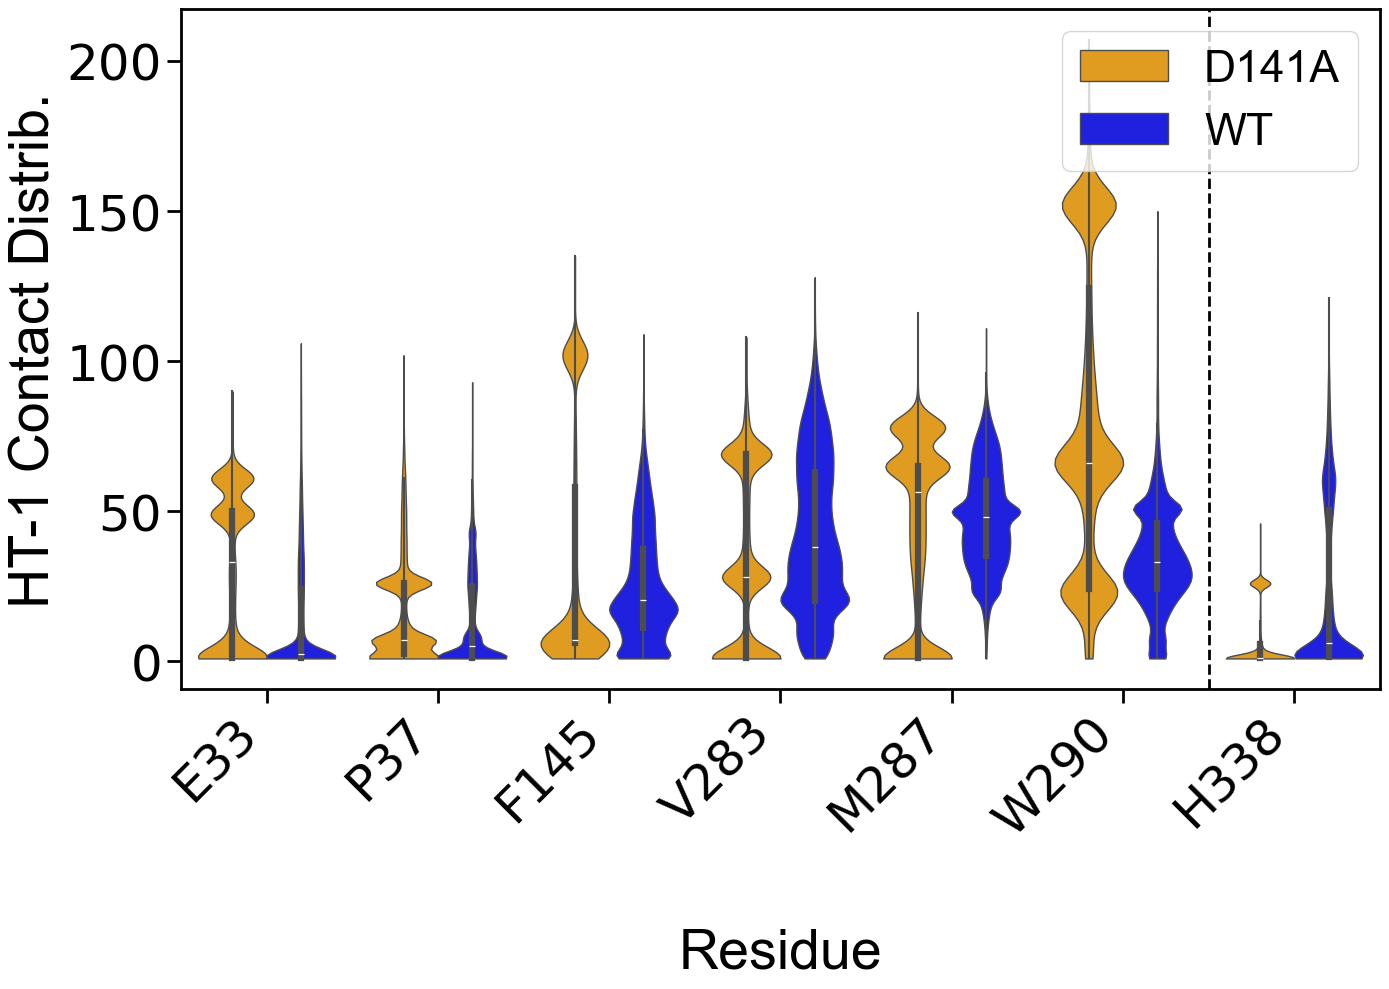


链 BmrC 包含以下残基:
E33, P37, F145, V283, M287, W290

链 BmrD 包含以下残基:
H338


In [156]:
import pandas as pd
import MDAnalysis as mda
from MDAnalysis.lib import transformations
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager

import matplotlib.path as mpath
import matplotlib.patches as mpatches

# -------------------------------
# 1) 定义三字母到单字母氨基酸代码的映射
# -------------------------------
three_to_one_map = {
    "ALA": "A", "CYS": "C", "ASP": "D", "GLU": "E", "PHE": "F", "GLY": "G",
    "HIS": "H", "ILE": "I", "LYS": "K", "LEU": "L", "MET": "M", "ASN": "N",
    "PRO": "P", "GLN": "Q", "ARG": "R", "SER": "S", "THR": "T", "VAL": "V",
    "TRP": "W", "TYR": "Y", "HSD": "H", "HIE": "H", "HIP": "H", "CYX": "C",
    "GLH": "E", "ASH": "D", "LYN": "K", "HID": "H"
}

def three_to_one(residue_name):
    """
    将三字母氨基酸代码转换为单字母代码。
    如果三字母代码未在映射中找到，则返回原始代码。
    """
    return three_to_one_map.get(residue_name.upper(), residue_name)

# -------------------------------
# 2) 解析 PSF 文件，提取 chain 和残基编号
# -------------------------------
def parse_psf_chain_residues(psf_path):
    """
    使用 MDAnalysis 解析 PSF 文件以提取链和残基编号信息。
    返回一个包含 [residue_label, Chain] 的DataFrame。
    """
    try:
        u = mda.Universe(psf_path)
    except Exception as e:
        print(f"无法解析 PSF 文件: {e}")
        return None
    
    data = []
    for res in u.residues:
        chain_id = res.segid.strip() if res.segid.strip() else "Unknown"
        res_num = res.resid
        res_name = three_to_one(res.resname)
        
        data.append({
            'residue_label': f"{res_name}{res_num}",
            'Chain': chain_id
        })
    
    df_psf = pd.DataFrame(data)
    df_psf.drop_duplicates(subset=['residue_label'], inplace=True)
    df_psf.reset_index(drop=True, inplace=True)
    
    return df_psf

# -------------------------------
# 3) 自定义函数: 绘制水平花括号 (brace)
# -------------------------------
def draw_curly_brace(ax, xstart, xend, y, text="", color='k', lw=2, fontsize=16):
    """
    在 (xstart -> xend) 范围内、以 y 为中心，绘制一个近似的水平花括号，并在其下方居中写上 text。
    这是用 Bezier 曲线画的简易形状，clip_on=False 以便超出坐标轴可见。
    """
    length = xend - xstart
    if length < 0:
        length = -length
        xstart, xend = xend, xstart

    verts = [
        (0.0, 0.5),  # 起点：左上
        (0.0, 0.0),  # 直线向下：左下
        (1.0, 0.0),  # 横线向右
        (1.0, -0.5)  # 直线向下：右下
    ]
    codes = [
        mpath.Path.MOVETO,  # 移动到起点
        mpath.Path.LINETO,  # 画直线到左下
        mpath.Path.LINETO,  # 画横线到右
        mpath.Path.LINETO   # 画直线到右下
    ]

    # 在 x 方向缩放到 length，y 方向做一点微缩
    xscale = length
    yscale = 0.3
    transformed_verts = []
    for vx, vy in verts:
        tx = xstart + vx * xscale
        ty = y + vy * yscale
        transformed_verts.append((tx, ty))

    path = mpath.Path(transformed_verts, codes)
    patch = mpatches.PathPatch(path, fill=False, color=color, lw=lw, clip_on=False)
    ax.add_patch(patch)

    # 在花括号正下方居中写上文字，增加偏移量
    ax.text(
        xstart + xscale/2,
        y - 0.6,  # 增加偏移量
        text,
        ha='center',
        va='top',
        fontsize=fontsize,
        color=color,
        clip_on=False
    )

# -------------------------------
# 4) 指定 PSF 文件路径并解析
# -------------------------------
psf_path = "/Scr/msincla01/BmrCD/of-state/analysis/trajs/rep1.psf"
df_psf = parse_psf_chain_residues(psf_path)

if df_psf is None:
    print("解析 PSF 文件失败。无法继续。")
else:
    print("PSF 文件解析结果 (前5行):")
    display(df_psf.head())

# -------------------------------
# 5) 获取或定义 df_interpolated (示例)
# -------------------------------
try:
    df_interpolated
except NameError:
    print("警告: 数据框 'df_interpolated' 不存在，使用示例数据！")
    data_example = {
        'residue_label': ['E33', 'A34', 'K45', 'R46', 'E33', 'K45'],
        'system': ['WT', 'Mutant', 'WT', 'Mutant', 'WT', 'Mutant'],
        'contact_count': [12, 15, 11, 14, 13, 16]
    }
    df_interpolated = pd.DataFrame(data_example)

# -------------------------------
# 6) 合并 df_interpolated 与 df_psf
# -------------------------------
if df_psf is not None and not df_interpolated.empty:
    df_merged = pd.merge(df_interpolated, df_psf, on='residue_label', how='left')
    
    # 无法匹配的先填充 Unknown
    missing = df_merged['Chain'].isnull().sum()
    if missing > 0:
        print(f"警告: 有 {missing} 个残基未匹配到链信息, 填充为Unknown。")
        df_merged['Chain'] = df_merged['Chain'].fillna("Unknown")
    
    print("df_merged.head():")
    display(df_merged.head(10))
    
    # 如果实际的链ID为 "C"/"D"，而我们想把它命名为 "BmrC"/"BmrD"
    chain_replace_dict = {"C": "BmrC", "D": "BmrD"}
    df_merged['Chain'] = df_merged['Chain'].replace(chain_replace_dict)
    
    print("合并并替换后，链ID汇总:")
    print(df_merged['Chain'].value_counts(dropna=False))
    
    # 替换 'Mutant' & 'MT' => 'D141A'
    df_merged["system"] = df_merged["system"].replace({"Mutant": "D141A", "MT": "D141A"})
    unique_systems = df_merged["system"].unique()
    print("Unique systems after replacement:", unique_systems)

    # 动态生成调色板
    unique_systems_sorted = sorted(unique_systems)
    palette_colors = sns.color_palette("husl", len(unique_systems_sorted))
    palette = {
    "D141A": "orange",  # 自定义颜色
    "WT": "blue"      # 自定义颜色
}

    
    # -------------------------------
    # 7) 根据阈值筛选感兴趣残基
    # -------------------------------
    contact_threshold = 15  # 可根据需要调整阈值
    residues_of_interest = (
        df_merged.groupby("residue_label")["contact_count"]
        .mean()
        .loc[lambda x: x >= contact_threshold]
        .index.tolist()
    )
    
    print("符合阈值的残基数:", len(residues_of_interest))
    if len(residues_of_interest) < 1:
        print("Warning: 没有任何残基均值超过阈值，无法绘图。")
    else:
        plot_data = df_merged[df_merged["residue_label"].isin(residues_of_interest)].copy()
        print("plot_data 行数:", len(plot_data))
        display(plot_data.head(10))
        
        if 'Chain' not in plot_data.columns:
            print("错误: 'Chain' 列不存在于合并后的数据框中。")
        else:
            # -------------------------------
            # 8) 用 violinplot 单轴绘图
            # -------------------------------
            
            # 分别获取 BmrC / BmrD 的残基，并排序
            chainC = plot_data.loc[plot_data["Chain"]=="BmrC","residue_label"].unique().tolist()
            chainD = plot_data.loc[plot_data["Chain"]=="BmrD","residue_label"].unique().tolist()
            
            def residue_num(res):
                return int("".join(filter(str.isdigit, res)))  # 提取数字用于排序
            
            chainC_sorted = sorted(chainC, key=residue_num)
            chainD_sorted = sorted(chainD, key=residue_num)
            residue_order = chainC_sorted + chainD_sorted
            
            print("BmrC 残基数:", len(chainC_sorted))
            print("BmrD 残基数:", len(chainD_sorted))
            
            fig = plt.figure(figsize=(14, 10))
            ax = fig.add_subplot(111)
            
            # 如果只有2种 system, 想要镜像显示可加 split=True
            ax = sns.violinplot(
                data=plot_data,
                x="residue_label",
                y="contact_count",
                hue="system",
                order=residue_order,
                palette=palette,
                cut=0,
                scale="width",
                linewidth=1,
                # split=True,  # 若仅两种状态且想要镜像可开启
                ax=ax
            )
            
            # 中间分隔线（BmrC和BmrD的交界）
            plt.axvline(
                x=len(chainC_sorted)-0.5, 
                color='black', 
                linestyle='--', 
                linewidth=2
            )
            
            # 坐标轴 & 刻度
            # 调整刻度线宽度和长度
            ax.tick_params(axis='both', which='major', width=2, length=10)
            ax.set_xlabel("Residue", fontsize=40, fontname='Arial', labelpad=60)
            ax.set_ylabel("HT-1 Contact Distrib.", fontsize=40, fontname='Arial')
            ax.tick_params(axis='x', labelsize=36)
            ax.tick_params(axis='y', labelsize=36)
            plt.xticks(rotation=45, ha='right')
            
            # 加粗边框
            for spine in ax.spines.values():
                spine.set_linewidth(2)
            
            # 为了能在下方画花括号，我们手动稍微扩展一下下边距
            plt.subplots_adjust(bottom=0.35)
            
            # 先获取当前 y 轴范围
            y_min, y_max = ax.get_ylim()
            # 我们让下限进一步下移，如 -4
            new_ymin = min(y_min, 0)
            ax.set_ylim(new_ymin, y_max)
            
            # 关闭坐标轴的 clip 限制（或对patch设置 clip_on=False）即可让花括号超出坐标
            # draw_curly_brace: 在下方 y=-3.0 画BmrC / BmrD花括号
            x_left_brace_start = -0.5
            x_left_brace_end   = len(chainC_sorted)-0.5
            
            x_right_brace_start = len(chainC_sorted)-0.5
            x_right_brace_end   = len(chainC_sorted) + len(chainD_sorted) - 0.5
            
            brace_y = -1.8  # 下移至 -3.0
            
            
            # 图例
            legend_font = font_manager.FontProperties(family='Arial', size=32)
            ax.legend(
#                title="System",
                title_fontsize=32,
                prop=legend_font,
                loc='upper right',
                frameon=True
            )
            
            plt.tight_layout()
            
            save_path = "/Scr/yunsenz2/data/BmrCD/figure/HT1_contact_new_distribution.png"
            plt.savefig(save_path, dpi=300, bbox_inches='tight', format='png')
            plt.show()
            
            # -------------------------------
            # 9) 可选：打印每条链的残基
            # -------------------------------
            chain_dict = {}
            for index, row in plot_data.iterrows():
                ch = row['Chain']
                res = row['residue_label']
                if ch not in chain_dict:
                    chain_dict[ch] = set()
                chain_dict[ch].add(res)
            
            for ch, residues in chain_dict.items():
                sorted_res = sorted(residues, key=lambda x: int("".join(filter(str.isdigit, x))))
                print(f"\n链 {ch} 包含以下残基:")
                print(", ".join(sorted_res))


开始处理 WT 轨迹: /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep1.dcd


/Scr/yunsenz2/data/software/miniconda3/envs/mdanalysis/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


初始帧中，预选到 9 个带电蛋白原子 (cutoff=12.0 Å)。
开始处理 WT 轨迹: /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep2.dcd


/Scr/yunsenz2/data/software/miniconda3/envs/mdanalysis/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


初始帧中，预选到 10 个带电蛋白原子 (cutoff=12.0 Å)。
开始处理 WT 轨迹: /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep4.dcd


/Scr/yunsenz2/data/software/miniconda3/envs/mdanalysis/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


初始帧中，预选到 12 个带电蛋白原子 (cutoff=12.0 Å)。
WT 合并后 DataFrame 形状: (31076, 6)
开始处理 Mutant 轨迹: /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep1.dcd


/Scr/yunsenz2/data/software/miniconda3/envs/mdanalysis/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


初始帧中，预选到 10 个带电蛋白原子 (cutoff=12.0 Å)。
开始处理 Mutant 轨迹: /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep2.dcd


/Scr/yunsenz2/data/software/miniconda3/envs/mdanalysis/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


初始帧中，预选到 10 个带电蛋白原子 (cutoff=12.0 Å)。
开始处理 Mutant 轨迹: /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep3.dcd


/Scr/yunsenz2/data/software/miniconda3/envs/mdanalysis/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


初始帧中，预选到 14 个带电蛋白原子 (cutoff=12.0 Å)。
Mutant 合并后 DataFrame 形状: (6932, 6)
所有数据合并后 DataFrame 形状: (38008, 6)
示例输出（前 5 行）：
   frame  time residue_label  ionic_bond_count system  \
0      0   0.0           E33                10     WT   
1      0   0.0          D141                35     WT   
2      1   2.0           E33                10     WT   
3      1   2.0          D141                30     WT   
4      2   4.0           E33                 8     WT   

                                           traj_file  
0  /Scr/msincla01/BmrCD/of-state/analysis/trajs/r...  
1  /Scr/msincla01/BmrCD/of-state/analysis/trajs/r...  
2  /Scr/msincla01/BmrCD/of-state/analysis/trajs/r...  
3  /Scr/msincla01/BmrCD/of-state/analysis/trajs/r...  
4  /Scr/msincla01/BmrCD/of-state/analysis/trajs/r...  
平均离子键数最高的前 5 个残基：
residue_label
D141    15.920292
E33     12.361513
E297     8.019048
D44      4.053140
D45      3.643678
Name: ionic_bond_count, dtype: float64


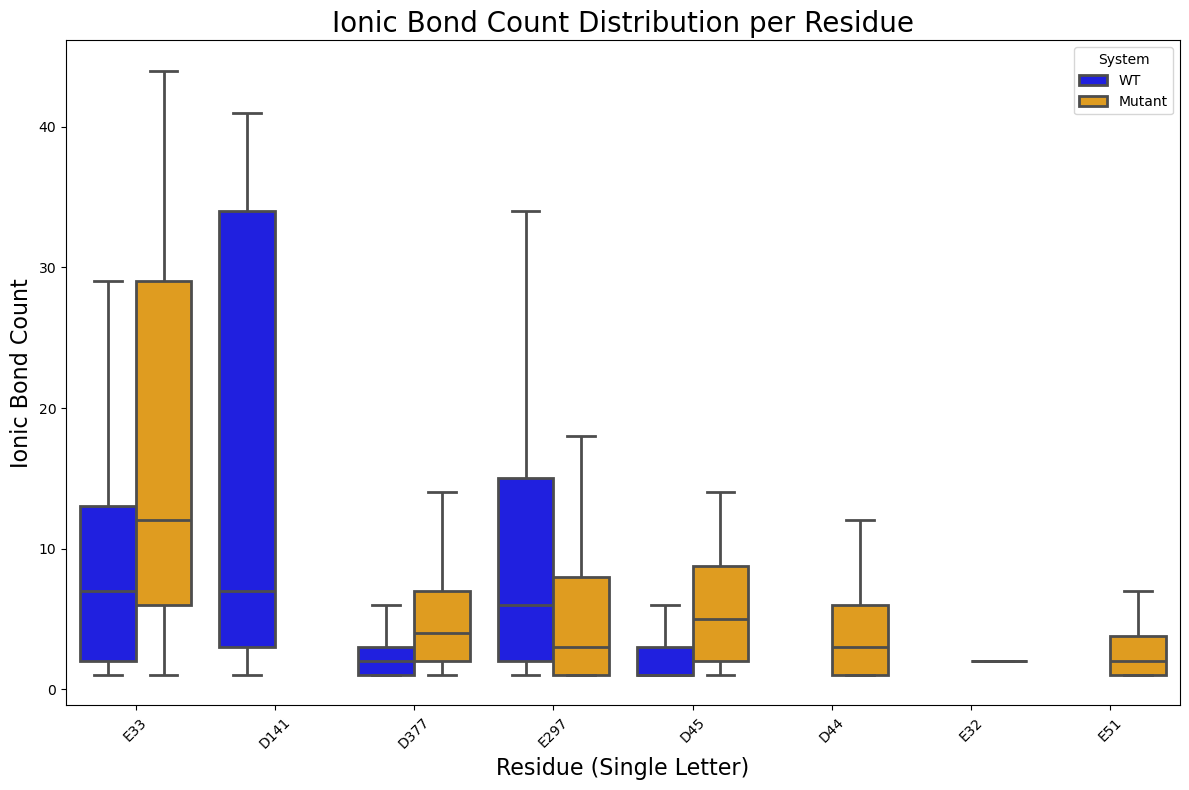

In [154]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import matplotlib.pyplot as plt
import re  # 引入正则表达式模块

# 定义三字母到单字母氨基酸代码的映射
three_to_one_map = {
    "ALA": "A", "CYS": "C", "ASP": "D", "GLU": "E", "PHE": "F", "GLY": "G",
    "HIS": "H", "ILE": "I", "LYS": "K", "LEU": "L", "MET": "M", "ASN": "N",
    "PRO": "P", "GLN": "Q", "ARG": "R", "SER": "S", "THR": "T", "VAL": "V",
    "TRP": "W", "TYR": "Y", "HSD": "H", "HIE": "H", "HIP": "H", "CYX": "C",
    "GLH": "E", "ASH": "D", "LYN": "K", "HID": "H"
}

def load_single_trajectory(psf_file, dcd_file):
    """
    加载单个 PSF + DCD 生成 Universe。
    """
    u = mda.Universe(psf_file, dcd_file)
    return u

def preselect_protein_charged_near_ligand(u,
                                          ligand_sel="resid 3 and resname HT1",
                                          protein_charged_sel=None,
                                          initial_cutoff=12.0):
    """
    可选的预选函数：在初始帧上选出距离配体 'initial_cutoff' 以内的蛋白带电原子，减少后续计算量。
    注意将 initial_cutoff 设得较大，以防遗漏潜在的离子键残基。
    """
    # 选择配体
    ligand = u.select_atoms(ligand_sel)
    if len(ligand) == 0:
        print("警告：未找到配体原子，请检查 ligand_sel 选择器。")
        return mda.AtomGroup([])

    # 如果没有特别指定，则用以下默认选择器
    if protein_charged_sel is None:
        protein_charged_sel = (
            "(resname ARG LYS) and (name NE* NH* CZ NZ*) or "
            "(resname ASP GLU) and (name OD* OE*)"
        )
        # 如果想包含 HIS(HIP/HID/HIE)、末端带电基团等，也可扩展选择器

    # 移动到第 0 帧
    u.trajectory[0]

    # 选择蛋白中带电原子
    charged_protein = u.select_atoms(protein_charged_sel)
    if len(charged_protein) == 0:
        print("警告：选择器未找到任何带电蛋白原子。请检查命名。")
        return mda.AtomGroup([])

    # 计算配体-蛋白距离矩阵
    distances = mda.lib.distances.distance_array(ligand.positions, charged_protein.positions)

    # 对每个蛋白原子取最小距离，以便判断它离配体最近的原子有多远
    min_distances = distances.min(axis=0)

    # 小于 initial_cutoff 的蛋白原子
    protein_near_ligand = charged_protein[min_distances < initial_cutoff]

    print(f"初始帧中，预选到 {len(protein_near_ligand)} 个带电蛋白原子 (cutoff={initial_cutoff} Å)。")
    return protein_near_ligand

def convert_to_single_letter(resname):
    """
    将三字母氨基酸代码转换为单字母代码。
    如果转换失败，则返回原始代码。
    """
    return three_to_one_map.get(resname.upper(), resname[0].upper())

def compute_ionic_timeseries_optimized(psf_file,
                                       dcd_file,
                                       ligand_sel="resid 3 and resname HT1",
                                       protein_charged_sel=None,
                                       ionic_cutoff=4.0,
                                       initial_cutoff=12.0,
                                       dt=2.0,
                                       use_preselection=True):
    """
    计算给定配体与蛋白带电原子之间的离子键时间序列（基于距离判定）。
    ionic_cutoff: 小于该距离即认为形成“离子键”。
    initial_cutoff: 预选距离，用于第一帧选原子 (可选)。
    dt: 每帧间隔时间 (ps)。
    """
    # 载入轨迹
    u = load_single_trajectory(psf_file, dcd_file)
    
    # 选择配体原子
    ligand_atoms = u.select_atoms(ligand_sel)
    if len(ligand_atoms) == 0:
        print(f"警告：在 {dcd_file} 中未找到配体 (ligand_sel={ligand_sel})。跳过。")
        return pd.DataFrame(columns=["frame", "time", "residue_label", "ionic_bond_count"])

    # 如果使用预选
    if use_preselection:
        protein_near_ligand = preselect_protein_charged_near_ligand(
            u,
            ligand_sel=ligand_sel,
            protein_charged_sel=protein_charged_sel,
            initial_cutoff=initial_cutoff
        )
    else:
        # 不做预选，直接选所有带电蛋白原子
        if protein_charged_sel is None:
            protein_charged_sel = (
                "(resname ARG LYS) and (name NE* NH* CZ NZ*) or "
                "(resname ASP GLU) and (name OD* OE*)"
            )
        protein_near_ligand = u.select_atoms(protein_charged_sel)

    # 如果为空，直接返回空表
    if len(protein_near_ligand) == 0:
        print(f"警告：在 {dcd_file} 中无可用带电蛋白原子。跳过。")
        return pd.DataFrame(columns=["frame", "time", "residue_label", "ionic_bond_count"])

    records = []

    for ts in u.trajectory:
        frame_index = ts.frame
        current_time = frame_index * dt  # 时间(ps)

        # 计算 ligand_atoms 与 protein_near_ligand 的距离矩阵
        dist_array = mda.lib.distances.distance_array(ligand_atoms.positions,
                                                      protein_near_ligand.positions)

        # 判定小于 ionic_cutoff 的为“离子键”
        ionic_matrix = (dist_array < ionic_cutoff)

        # residue_ionic_count[key] 统计每个残基下有多少对原子-原子距离 < ionic_cutoff
        residue_ionic_count = defaultdict(int)

        for i in range(ionic_matrix.shape[0]):
            for j in range(ionic_matrix.shape[1]):
                if ionic_matrix[i, j]:
                    pro_atom = protein_near_ligand[j]
                    # 将三字母代码转换为单字母代码
                    single_letter = convert_to_single_letter(pro_atom.resname)
                    key = f"{single_letter}{pro_atom.resid}"
                    residue_ionic_count[key] += 1

        # 保存当前帧信息
        for res_label, count in residue_ionic_count.items():
            records.append((frame_index, current_time, res_label, count))

    # 转为 DataFrame
    df = pd.DataFrame(records, columns=["frame", "time", "residue_label", "ionic_bond_count"])
    return df


# -------------------- 以下为示例使用代码 --------------------

# 文件路径（示例）
wt_psf = "/Scr/msincla01/BmrCD/of-state/analysis/trajs/rep1.psf"
wt_dcd_list = [
    "/Scr/msincla01/BmrCD/of-state/analysis/trajs/rep1.dcd",
    "/Scr/msincla01/BmrCD/of-state/analysis/trajs/rep2.dcd",
    "/Scr/msincla01/BmrCD/of-state/analysis/trajs/rep4.dcd"
]

mut_psf = "/Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep1.psf"
mut_dcd_list = [
    "/Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep1.dcd",
    "/Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep2.dcd",
    "/Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep3.dcd"
]

# 分析 WT
df_wt_list = []
for dcd_file in wt_dcd_list:
    print(f"开始处理 WT 轨迹: {dcd_file}")
    df_wt_contact = compute_ionic_timeseries_optimized(
        psf_file=wt_psf,
        dcd_file=dcd_file,
        ligand_sel="resid 3 and resname HT1",   # 根据自己体系调整
        protein_charged_sel=None,               # 若不指定，就用默认带电原子选择器
        ionic_cutoff=5.0,                       # 定义离子键距离
        initial_cutoff=12.0,                    # 预选距离（设置大一点）
        dt=2.0,
        use_preselection=True                   # 使用预选
    )
    if not df_wt_contact.empty:
        df_wt_contact["system"] = "WT"
        df_wt_contact["traj_file"] = dcd_file
        df_wt_list.append(df_wt_contact)

# 合并 WT 数据
df_wt_combined = pd.concat(df_wt_list, ignore_index=True) if df_wt_list else pd.DataFrame()
print(f"WT 合并后 DataFrame 形状: {df_wt_combined.shape}")

# 分析 Mutant
df_mut_list = []
for dcd_file in mut_dcd_list:
    print(f"开始处理 Mutant 轨迹: {dcd_file}")
    df_mut_contact = compute_ionic_timeseries_optimized(
        psf_file=mut_psf,
        dcd_file=dcd_file,
        ligand_sel="resid 3 and resname HT1",
        protein_charged_sel=None,
        ionic_cutoff=5.0,
        initial_cutoff=12.0,
        dt=2.0,
        use_preselection=True
    )
    if not df_mut_contact.empty:
        df_mut_contact["system"] = "Mutant"
        df_mut_contact["traj_file"] = dcd_file
        df_mut_list.append(df_mut_contact)

# 合并 Mutant 数据
df_mut_combined = pd.concat(df_mut_list, ignore_index=True) if df_mut_list else pd.DataFrame()
print(f"Mutant 合并后 DataFrame 形状: {df_mut_combined.shape}")

# 合并所有数据
df_all = pd.concat([df_wt_combined, df_mut_combined], ignore_index=True) \
    if not df_wt_combined.empty or not df_mut_combined.empty else pd.DataFrame()
print(f"所有数据合并后 DataFrame 形状: {df_all.shape}")


if df_all.empty:
    print("警告：没有获取到任何离子键统计数据。请检查选择器与距离参数。")
else:
    print("示例输出（前 5 行）：")
    print(df_all.head())

    # 计算每个残基的平均离子键数
    avg_bonds = df_all.groupby("residue_label")["ionic_bond_count"].mean().sort_values(ascending=False)
    print("平均离子键数最高的前 5 个残基：")
    print(avg_bonds.head(5))

    # 可视化示例：挑选“平均离子键数大于阈值”的残基
    threshold = 1
    residues_of_interest = avg_bonds[avg_bonds >= threshold].index.tolist()
    
    if residues_of_interest:
        plot_data = df_all[df_all["residue_label"].isin(residues_of_interest)].copy()
       
        plt.figure(figsize=(12, 8))#

        # Create a box plot
        sns.boxplot(
            data=plot_data,
            x="residue_label",
            y="ionic_bond_count",
            hue="system",
            palette={"WT": "blue", "Mutant": "orange"},  # Match colors with the line plot style
            showfliers=False,  # Do not show outliers
            linewidth=2  # Thicker lines for the boxplot
        )

        # 添加标题和标签
        plt.title("Ionic Bond Count Distribution per Residue", fontsize=20)
        plt.xlabel("Residue (Single Letter)", fontsize=16)
        plt.ylabel("Ionic Bond Count", fontsize=16)
        plt.xticks(rotation=45)
        plt.legend(title="System")
        plt.tight_layout()
        plt.show()


df_merged.head():


,frame,time,residue_label,ionic_bond_count,system,traj_file,Chain
0,0,0.0,E33,10,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,C
1,0,0.0,D141,35,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,C
2,1,2.0,E33,10,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,C
3,1,2.0,D141,30,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,C
4,2,4.0,E33,8,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,C
5,2,4.0,D141,31,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,C
6,3,6.0,E33,11,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,C
7,3,6.0,D141,34,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,C
8,4,8.0,E33,15,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,C
9,4,8.0,D141,31,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,C


合并并替换后，链ID汇总:
Chain
BmrC    28280
BmrD     9728
Name: count, dtype: int64
Unique systems after replacement: ['WT' 'D141A']
符合阈值的残基数: 4
plot_data 行数: 28400


,frame,time,residue_label,ionic_bond_count,system,traj_file,Chain
0,0,0.0,E33,10,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,BmrC
1,0,0.0,D141,35,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,BmrC
2,1,2.0,E33,10,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,BmrC
3,1,2.0,D141,30,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,BmrC
4,2,4.0,E33,8,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,BmrC
5,2,4.0,D141,31,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,BmrC
6,3,6.0,E33,11,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,BmrC
7,3,6.0,D141,34,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,BmrC
8,4,8.0,E33,15,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,BmrC
9,4,8.0,D141,31,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,BmrC


BmrC 残基数: 3
BmrD 残基数: 1


/tmp/ipykernel_3565795/3331338344.py:74: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


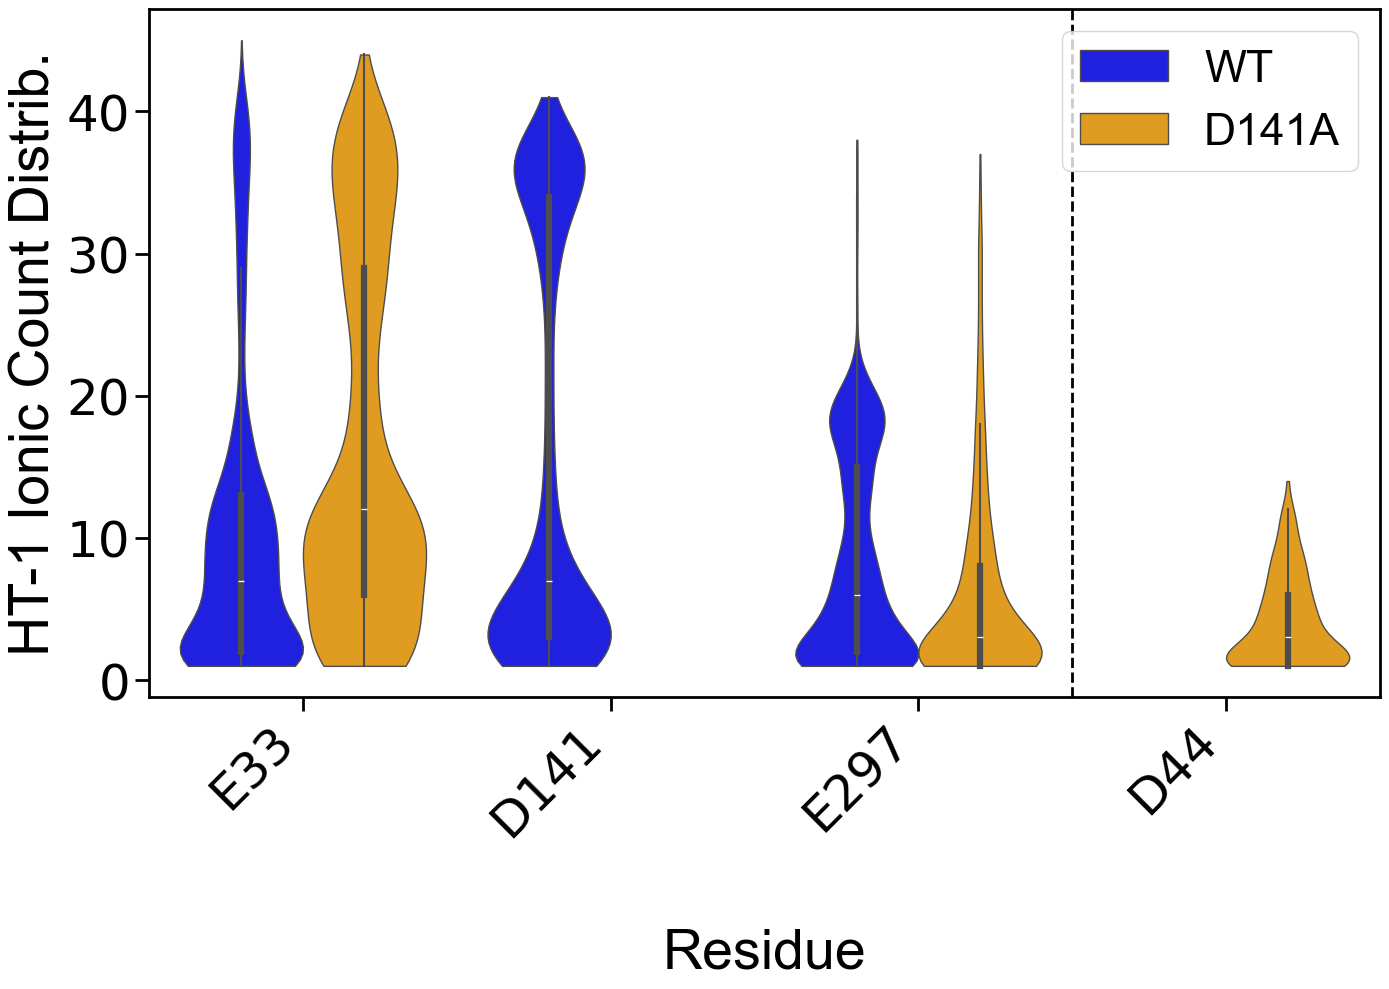


链 BmrC 包含以下残基:
E33, D141, E297

链 BmrD 包含以下残基:
D44


In [155]:
if df_psf is not None and not plot_data.empty:
    df_merged = pd.merge(plot_data, df_psf, on='residue_label', how='left')
    
    # 无法匹配的先填充 Unknown
    missing = df_merged['Chain'].isnull().sum()
    if missing > 0:
        print(f"警告: 有 {missing} 个残基未匹配到链信息, 填充为Unknown。")
        df_merged['Chain'] = df_merged['Chain'].fillna("Unknown")
    
    print("df_merged.head():")
    display(df_merged.head(10))
    
    # 如果实际的链ID为 "C"/"D"，而我们想把它命名为 "BmrC"/"BmrD"
    chain_replace_dict = {"C": "BmrC", "D": "BmrD"}
    df_merged['Chain'] = df_merged['Chain'].replace(chain_replace_dict)
    
    print("合并并替换后，链ID汇总:")
    print(df_merged['Chain'].value_counts(dropna=False))
    
    # 替换 'Mutant' & 'MT' => 'D141A'
    df_merged["system"] = df_merged["system"].replace({"Mutant": "D141A", "MT": "D141A"})
    unique_systems = df_merged["system"].unique()
    print("Unique systems after replacement:", unique_systems)

    # 定义调色板
    palette = {
        "D141A": "orange",  # 自定义颜色
        "WT": "blue"         # 自定义颜色
    }
    
    # -------------------------------
    # 7) 根据阈值筛选感兴趣残基
    # -------------------------------
    contact_threshold = 4  # 可根据需要调整阈值
    residues_of_interest = (
        df_merged.groupby("residue_label")["ionic_bond_count"]
        .mean()
        .loc[lambda x: x >= contact_threshold]
        .index.tolist()
    )
    
    print("符合阈值的残基数:", len(residues_of_interest))
    if len(residues_of_interest) < 1:
        print("Warning: 没有任何残基均值超过阈值，无法绘图。")
    else:
        plot_data_filtered = df_merged[df_merged["residue_label"].isin(residues_of_interest)].copy()
        print("plot_data 行数:", len(plot_data_filtered))
        display(plot_data_filtered.head(10))
        
        if 'Chain' not in plot_data_filtered.columns:
            print("错误: 'Chain' 列不存在于合并后的数据框中。")
        else:
            # -------------------------------
            # 8) 用 violinplot 单轴绘图
            # -------------------------------
            
            # 分别获取 BmrC / BmrD 的残基，并排序
            chainC = plot_data_filtered.loc[plot_data_filtered["Chain"]=="BmrC","residue_label"].unique().tolist()
            chainD = plot_data_filtered.loc[plot_data_filtered["Chain"]=="BmrD","residue_label"].unique().tolist()
            
            def residue_num(res):
                return int("".join(filter(str.isdigit, res)))  # 提取数字用于排序
            
            chainC_sorted = sorted(chainC, key=residue_num)
            chainD_sorted = sorted(chainD, key=residue_num)
            residue_order = chainC_sorted + chainD_sorted
            
            print("BmrC 残基数:", len(chainC_sorted))
            print("BmrD 残基数:", len(chainD_sorted))
            
            fig = plt.figure(figsize=(14, 10))
            ax = fig.add_subplot(111)
            
            ax = sns.violinplot(
                data=plot_data_filtered,
                x="residue_label",
                y="ionic_bond_count",
                hue="system",
                order=residue_order,
                palette=palette,
                cut=0,
                scale="width",
                linewidth=1,
                ax=ax
            )
            
            # 中间分隔线（BmrC和BmrD的交界）
            plt.axvline(
                x=len(chainC_sorted)-0.5, 
                color='black', 
                linestyle='--', 
                linewidth=2
            )
            
            # 坐标轴 & 刻度
                # 调整刻度线宽度和长度
            ax.tick_params(axis='both', which='major', width=2, length=10)
            ax.set_xlabel("Residue", fontsize=40, fontname='Arial')
            ax.set_ylabel("HT-1 Ionic Count Distrib.", fontsize=40, fontname='Arial')
            ax.tick_params(axis='x', labelsize=36)
            ax.tick_params(axis='y', labelsize=36)
            plt.xticks(rotation=45, ha='right')
            
            # 加粗边框
            for spine in ax.spines.values():
                spine.set_linewidth(2)
            
            # 为了能在下方画花括号，我们手动稍微扩展一下下边距
            plt.subplots_adjust(bottom=0.35)
            
            # 先获取当前 y 轴范围
            y_min, y_max = ax.get_ylim()
            # 我们让下限进一步下移，如 -18
            new_ymin = min(y_min, -0)
            ax.set_ylim(new_ymin, y_max)
            
            # 关闭坐标轴的 clip 限制（或对patch设置 clip_on=False）即可让花括号超出坐标
            # draw_curly_brace: 在下方 y=-1.8 画BmrC / BmrD花括号
            x_left_brace_start = -0.5
            x_left_brace_end   = len(chainC_sorted)-0.5
            
            x_right_brace_start = len(chainC_sorted)-0.5
            x_right_brace_end   = len(chainC_sorted) + len(chainD_sorted) - 0.5
            
            
            # 图例
            legend_font = font_manager.FontProperties(family='Arial', size=32)
            ax.legend(
                title_fontsize=32,
                prop=legend_font,
                loc='upper right',
                frameon=True
            )
            ax.set_xlabel("Residue", fontsize=40, fontname='Arial', labelpad=60)  # 调整 Residue 标签的位置
            plt.tight_layout()
            
            save_path = "/Scr/yunsenz2/data/BmrCD/figure/HT1_ib_distribution.png"
            plt.savefig(save_path, dpi=300, bbox_inches='tight', format='png')
            plt.show()
            
            # -------------------------------
            # 9) 可选：打印每条链的残基
            # -------------------------------
            chain_dict = {}
            for index, row in plot_data_filtered.iterrows():
                ch = row['Chain']
                res = row['residue_label']
                if ch not in chain_dict:
                    chain_dict[ch] = set()
                chain_dict[ch].add(res)
            
            for ch, residues in chain_dict.items():
                sorted_res = sorted(residues, key=lambda x: int("".join(filter(str.isdigit, x))))
                print(f"\n链 {ch} 包含以下残基:")
                print(", ".join(sorted_res))


In [150]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from MDAnalysis.analysis.hydrogenbonds import HydrogenBondAnalysis
import inspect

# -------------------- 新增：3->1 氨基酸映射 --------------------
three_to_one_map = {
    "ALA": "A", "CYS": "C", "ASP": "D", "GLU": "E", "PHE": "F", "GLY": "G",
    "HIS": "H", "ILE": "I", "LYS": "K", "LEU": "L", "MET": "M", "ASN": "N",
    "PRO": "P", "GLN": "Q", "ARG": "R", "SER": "S", "THR": "T", "VAL": "V",
    "TRP": "W", "TYR": "Y", "HSD": "H", "HIE": "H", "HIP": "H", "CYX": "C",
    "GLH": "E", "ASH": "D", "LYN": "K", "HID": "H"
}

def three_to_one(resname):
    """
    将三字母氨基酸代码转换为单字母代码。
    未在映射中的残基，默认返回其第一个字母的大写。
    """
    return three_to_one_map.get(resname.upper(), resname[0].upper())


# -------------------- 版本与签名检查 --------------------
print("MDAnalysis version:", mda.__version__)
print("HydrogenBondAnalysis constructor signature:")
print(inspect.signature(HydrogenBondAnalysis.__init__))


def load_single_trajectory(psf_file, dcd_file):
    """
    加载单个 PSF + DCD 生成 Universe。
    """
    u = mda.Universe(psf_file, dcd_file)
    return u


def preselect_protein_near_ligand(u,
                                  ligand_sel="resid 3 and resname HT1",
                                  protein_sel="protein",
                                  initial_cutoff=8.0):
    """
    在初始帧上筛选出距离配体小于 initial_cutoff 的蛋白原子
    （可选，加快后续分析）。
    """
    # 移动到第0帧
    u.trajectory[0]

    # 选择配体原子
    ligand_atoms = u.select_atoms(ligand_sel)
    if len(ligand_atoms) == 0:
        print("警告：未找到配体原子。请检查 ligand_sel。")
        return mda.AtomGroup([])

    # 选择蛋白原子
    protein_atoms = u.select_atoms(protein_sel)
    if len(protein_atoms) == 0:
        print("警告：未找到蛋白原子。请检查 protein_sel。")
        return mda.AtomGroup([])

    # 计算配体与蛋白所有原子的距离矩阵
    dist_matrix = mda.lib.distances.distance_array(ligand_atoms.positions, protein_atoms.positions)
    min_distances = dist_matrix.min(axis=0)

    # 选出距离配体 < initial_cutoff 的蛋白原子
    near_protein = protein_atoms[min_distances < initial_cutoff]
    print(f"预选到 {len(near_protein)} 个蛋白原子（cutoff={initial_cutoff} Å）。")
    return near_protein


def compute_hbond_timeseries_newapi(psf_file,
                                    dcd_file,
                                    ligand_sel="resid 3 and resname HT1",
                                    protein_sel="protein",
                                    use_preselection=True,
                                    initial_cutoff=8.0,
                                    d_a_cutoff=3.0,            # Donor–Acceptor 最大距离 (Å)
                                    d_h_cutoff=1.2,            # Donor–Hydrogen 最大距离 (Å)
                                    d_h_a_angle_cutoff=150,    # Donor–Hydrogen–Acceptor 最小角度 (度)
                                    hydrogens_sel="name H*",   # 氢原子选择器
                                    update_selections=True,    # 是否更新选择器
                                    dt=2.0,
                                    step=5                     # 新增：仅分析每 5 帧
                                   ):
    """
    基于 MDAnalysis 新版本 HydrogenBondAnalysis API 的氢键分析。
    只统计“配体–蛋白”之间的氢键。
    返回 DataFrame: [frame, time, residue_label, hbond_count].
    """

    # 1. 载入 Universe
    u = load_single_trajectory(psf_file, dcd_file)

    # 2. 选择配体原子
    ligand_atoms = u.select_atoms(ligand_sel)
    if len(ligand_atoms) == 0:
        print(f"警告：在 {dcd_file} 中未找到配体 (sel={ligand_sel})，跳过。")
        return pd.DataFrame(columns=["frame", "time", "residue_label", "hbond_count"])

    # 3. 若预选，则先在初始帧上选出蛋白原子 (加速)
    if use_preselection:
        protein_near = preselect_protein_near_ligand(
            u, ligand_sel=ligand_sel, protein_sel=protein_sel, initial_cutoff=initial_cutoff
        )
        if len(protein_near) == 0:
            print(f"警告：在 {dcd_file} 中无蛋白原子被预选到，跳过。")
            return pd.DataFrame(columns=["frame", "time", "residue_label", "hbond_count"])
        # 用索引串成选择器
        protein_indices = " ".join(str(a.ix) for a in protein_near)
        protein_selection_str = f"index {protein_indices}"
    else:
        # 不做预选
        protein_selection_str = protein_sel

    # 4. 构建 “配体 + 蛋白(或局部)” 的综合选择器
    full_sel = f"({ligand_sel}) or ({protein_selection_str})"

    # 5. 运行 HydrogenBondAnalysis
    hb = HydrogenBondAnalysis(
        universe=u,
        donors_sel=full_sel,           # 与 acceptors_sel 相同，均为 full_sel
        acceptors_sel=full_sel,
        hydrogens_sel=hydrogens_sel,
        d_a_cutoff=d_a_cutoff,
        d_h_cutoff=d_h_cutoff,
        d_h_a_angle_cutoff=d_h_a_angle_cutoff,
        update_selections=update_selections
    )
    # 只分析每 step 帧
    hb.run(step=step)

    # 如果没有检测到氢键，直接返回空表
    if hb.hbonds.shape[0] == 0:
        print(f"警告：{dcd_file} 未检测到任何氢键。")
        return pd.DataFrame(columns=["frame", "time", "residue_label", "hbond_count"])

    # 6. 映射原子索引 -> (resname, resid)
    idx_to_res = {atom.ix: (atom.resname, atom.resid) for atom in u.atoms}

    # 7. 构建 “配体原子索引集合” 和 “蛋白原子索引集合”
    ligand_indices_set = set(ligand_atoms.indices)
    if use_preselection:
        protein_atoms = protein_near
    else:
        protein_atoms = u.select_atoms(protein_sel)
    protein_indices_set = set(protein_atoms.indices)

    # 8. 拿到氢键结果表: [frame, donor_idx, hydrogen_idx, acceptor_idx, distance, angle]
    hb_df = pd.DataFrame(hb.hbonds, columns=["frame", "donor_idx", "hyd_idx", "acceptor_idx", "distance", "angle"])

    # 只保留“跨配体-蛋白”的氢键
    def is_cross_ligand_protein(row):
        donor_i = int(row["donor_idx"])
        acceptor_i = int(row["acceptor_idx"])
        donor_in_lig = (donor_i in ligand_indices_set)
        acceptor_in_lig = (acceptor_i in ligand_indices_set)
        return (donor_in_lig and (acceptor_i in protein_indices_set)) or \
               ((donor_i in protein_indices_set) and acceptor_in_lig)

    hb_df["is_cross"] = hb_df.apply(is_cross_ligand_protein, axis=1)
    hb_cross = hb_df[hb_df["is_cross"] == True].copy()
    if hb_cross.empty:
        print(f"警告：{dcd_file} 检测到氢键，但无跨配体-蛋白氢键。")
        return pd.DataFrame(columns=["frame", "time", "residue_label", "hbond_count"])

    # 9. 确定蛋白残基 label (resname + resid) -> 输出单字母
    def get_protein_res_label(row):
        donor_i = int(row["donor_idx"])
        acceptor_i = int(row["acceptor_idx"])
        if donor_i in protein_indices_set:
            resname_3 = idx_to_res[donor_i][0]  # 三字母
            resid     = idx_to_res[donor_i][1]
        else:
            resname_3 = idx_to_res[acceptor_i][0]
            resid     = idx_to_res[acceptor_i][1]

        # 调用 three_to_one() 转换成单字母
        resname_1 = three_to_one(resname_3)
        return f"{resname_1}{resid}"

    hb_cross["residue_label"] = hb_cross.apply(get_protein_res_label, axis=1)

    # 10. 按 [frame, residue_label] 分组统计氢键数
    grouped = hb_cross.groupby(["frame", "residue_label"]).size().reset_index(name="hbond_count")

    # 11. 生成最终输出 DataFrame
    records = []
    for _, row in grouped.iterrows():
        frame_i = int(row["frame"])
        res_label = row["residue_label"]
        count = row["hbond_count"]
        # 若 dt=2.0 ps/帧，则 frame=5 表示 10 ps, frame=10 表示 20 ps, etc.
        time_ps = frame_i * dt
        records.append((frame_i, time_ps, res_label, count))

    out_df = pd.DataFrame(records, columns=["frame", "time", "residue_label", "hbond_count"])
    return out_df


# -------------------- 以下为示例调用代码 --------------------

# 文件路径（示例，请根据实际路径进行修改）
wt_psf = "/Scr/msincla01/BmrCD/of-state/analysis/trajs/rep1.psf"
wt_dcd_list = [
    "/Scr/msincla01/BmrCD/of-state/analysis/trajs/rep1.dcd",
    "/Scr/msincla01/BmrCD/of-state/analysis/trajs/rep2.dcd",
    "/Scr/msincla01/BmrCD/of-state/analysis/trajs/rep4.dcd"
]

mut_psf = "/Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep1.psf"
mut_dcd_list = [
    "/Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep1.dcd",
    "/Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep2.dcd",
    "/Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep3.dcd"
]

# -------------------- 分析 WT --------------------
df_wt_list = []
for dcd_file in wt_dcd_list:
    print(f"[HBond] 开始处理 WT 轨迹: {dcd_file}")
    df_wt_hbond = compute_hbond_timeseries_newapi(
        psf_file=wt_psf,
        dcd_file=dcd_file,
        ligand_sel="resid 3 and resname HT1",
        protein_sel="protein and not (resid 152 or resid 297)",
        use_preselection=True,
        initial_cutoff=8.0,
        d_a_cutoff=3.5,          # Donor–Acceptor 最大距离 (Å)
        d_h_cutoff=1.2,          # Donor–Hydrogen 最大距离 (Å)
        d_h_a_angle_cutoff=150,  # Donor–Hydrogen–Acceptor 最小角度 (度)
        hydrogens_sel="name H*",
        update_selections=True,
        dt=2.0,
        step=5                   # 仅分析每5帧
    )
    if not df_wt_hbond.empty:
        df_wt_hbond["system"] = "WT"
        df_wt_hbond["traj_file"] = dcd_file
        df_wt_list.append(df_wt_hbond)

df_wt_combined = pd.concat(df_wt_list, ignore_index=True) if df_wt_list else pd.DataFrame()
print(f"WT 合并后氢键 DataFrame 形状: {df_wt_combined.shape}")

# -------------------- 分析 Mutant --------------------
df_mut_list = []
for dcd_file in mut_dcd_list:
    print(f"[HBond] 开始处理 Mutant 轨迹: {dcd_file}")
    df_mut_hbond = compute_hbond_timeseries_newapi(
        psf_file=mut_psf,
        dcd_file=dcd_file,
        ligand_sel="resid 3 and resname HT1",
        protein_sel="protein and not (resid 152 or resid 297)",
        use_preselection=True,
        initial_cutoff=8.0,
        d_a_cutoff=3.5,
        d_h_cutoff=1.2,
        d_h_a_angle_cutoff=150,
        hydrogens_sel="name H*",
        update_selections=True,
        dt=2.0,
        step=5
    )
    if not df_mut_hbond.empty:
        df_mut_hbond["system"] = "Mutant"
        df_mut_hbond["traj_file"] = dcd_file
        df_mut_list.append(df_mut_hbond)

df_mut_combined = pd.concat(df_mut_list, ignore_index=True) if df_mut_list else pd.DataFrame()
print(f"Mutant 合并后氢键 DataFrame 形状: {df_mut_combined.shape}")

# -------------------- 合并 WT 和 Mutant 数据 --------------------
df_all = pd.concat([df_wt_combined, df_mut_combined], ignore_index=True) \
    if not df_wt_combined.empty or not df_mut_combined.empty else pd.DataFrame()
print(f"所有数据合并后氢键 DataFrame 形状: {df_all.shape}")

# 查看前几行，检查 residue_label 是否变为单字母（如 'D141'）
print(df_all.head(10))


MDAnalysis version: 2.8.0
HydrogenBondAnalysis constructor signature:
(self, universe, donors_sel=None, hydrogens_sel=None, acceptors_sel=None, between=None, d_h_cutoff=1.2, d_a_cutoff=3.0, d_h_a_angle_cutoff=150, update_selections=True)
[HBond] 开始处理 WT 轨迹: /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep1.dcd


/Scr/yunsenz2/data/software/miniconda3/envs/mdanalysis/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


预选到 500 个蛋白原子（cutoff=8.0 Å）。


/Scr/yunsenz2/data/software/miniconda3/envs/mdanalysis/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:808: DeprecationWarning: The `hbonds` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.hbonds` instead.
  warnings.warn(wmsg, DeprecationWarning)


[HBond] 开始处理 WT 轨迹: /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep2.dcd


/Scr/yunsenz2/data/software/miniconda3/envs/mdanalysis/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


预选到 540 个蛋白原子（cutoff=8.0 Å）。


/Scr/yunsenz2/data/software/miniconda3/envs/mdanalysis/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:808: DeprecationWarning: The `hbonds` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.hbonds` instead.
  warnings.warn(wmsg, DeprecationWarning)


[HBond] 开始处理 WT 轨迹: /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep4.dcd


/Scr/yunsenz2/data/software/miniconda3/envs/mdanalysis/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


预选到 576 个蛋白原子（cutoff=8.0 Å）。


/Scr/yunsenz2/data/software/miniconda3/envs/mdanalysis/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:808: DeprecationWarning: The `hbonds` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.hbonds` instead.
  warnings.warn(wmsg, DeprecationWarning)


WT 合并后氢键 DataFrame 形状: (15582, 6)
[HBond] 开始处理 Mutant 轨迹: /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep1.dcd


/Scr/yunsenz2/data/software/miniconda3/envs/mdanalysis/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


预选到 493 个蛋白原子（cutoff=8.0 Å）。


/Scr/yunsenz2/data/software/miniconda3/envs/mdanalysis/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:808: DeprecationWarning: The `hbonds` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.hbonds` instead.
  warnings.warn(wmsg, DeprecationWarning)


[HBond] 开始处理 Mutant 轨迹: /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep2.dcd


/Scr/yunsenz2/data/software/miniconda3/envs/mdanalysis/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


预选到 471 个蛋白原子（cutoff=8.0 Å）。


/Scr/yunsenz2/data/software/miniconda3/envs/mdanalysis/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:808: DeprecationWarning: The `hbonds` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.hbonds` instead.
  warnings.warn(wmsg, DeprecationWarning)


[HBond] 开始处理 Mutant 轨迹: /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep3.dcd


/Scr/yunsenz2/data/software/miniconda3/envs/mdanalysis/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


预选到 454 个蛋白原子（cutoff=8.0 Å）。


/Scr/yunsenz2/data/software/miniconda3/envs/mdanalysis/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:808: DeprecationWarning: The `hbonds` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.hbonds` instead.
  warnings.warn(wmsg, DeprecationWarning)


Mutant 合并后氢键 DataFrame 形状: (5277, 6)
所有数据合并后氢键 DataFrame 形状: (20859, 6)
   frame  time residue_label  hbond_count system  \
0      0   0.0          D141            2     WT   
1      0   0.0           E33            1     WT   
2      0   0.0           L26            1     WT   
3      0   0.0           M34            3     WT   
4      0   0.0          S280            1     WT   
5      0   0.0          V283            1     WT   
6      0   0.0           V29            1     WT   
7      0   0.0           W78            1     WT   
8      5  10.0          D141            1     WT   
9      5  10.0          F145            1     WT   

                                           traj_file  
0  /Scr/msincla01/BmrCD/of-state/analysis/trajs/r...  
1  /Scr/msincla01/BmrCD/of-state/analysis/trajs/r...  
2  /Scr/msincla01/BmrCD/of-state/analysis/trajs/r...  
3  /Scr/msincla01/BmrCD/of-state/analysis/trajs/r...  
4  /Scr/msincla01/BmrCD/of-state/analysis/trajs/r...  
5  /Scr/msincla01/BmrCD/o

氢键统计示例(前5行):
   frame  time residue_label  hbond_count system  \
0      0   0.0          D141            2     WT   
1      0   0.0           E33            1     WT   
2      0   0.0           L26            1     WT   
3      0   0.0           M34            3     WT   
4      0   0.0          S280            1     WT   

                                           traj_file  
0  /Scr/msincla01/BmrCD/of-state/analysis/trajs/r...  
1  /Scr/msincla01/BmrCD/of-state/analysis/trajs/r...  
2  /Scr/msincla01/BmrCD/of-state/analysis/trajs/r...  
3  /Scr/msincla01/BmrCD/of-state/analysis/trajs/r...  
4  /Scr/msincla01/BmrCD/of-state/analysis/trajs/r...  
平均氢键数最高的前 5 个残基:
residue_label
N42     4.750000
H338    4.219065
E33     3.491325
K38     3.242718
V376    2.973282
Name: hbond_count, dtype: float64
Unique systems after replacement: ['WT' 'D141A']
Sample converted residue labels:
1      E33
3      M34
5     V283
7      W78
10     K38
Name: residue_label, dtype: object


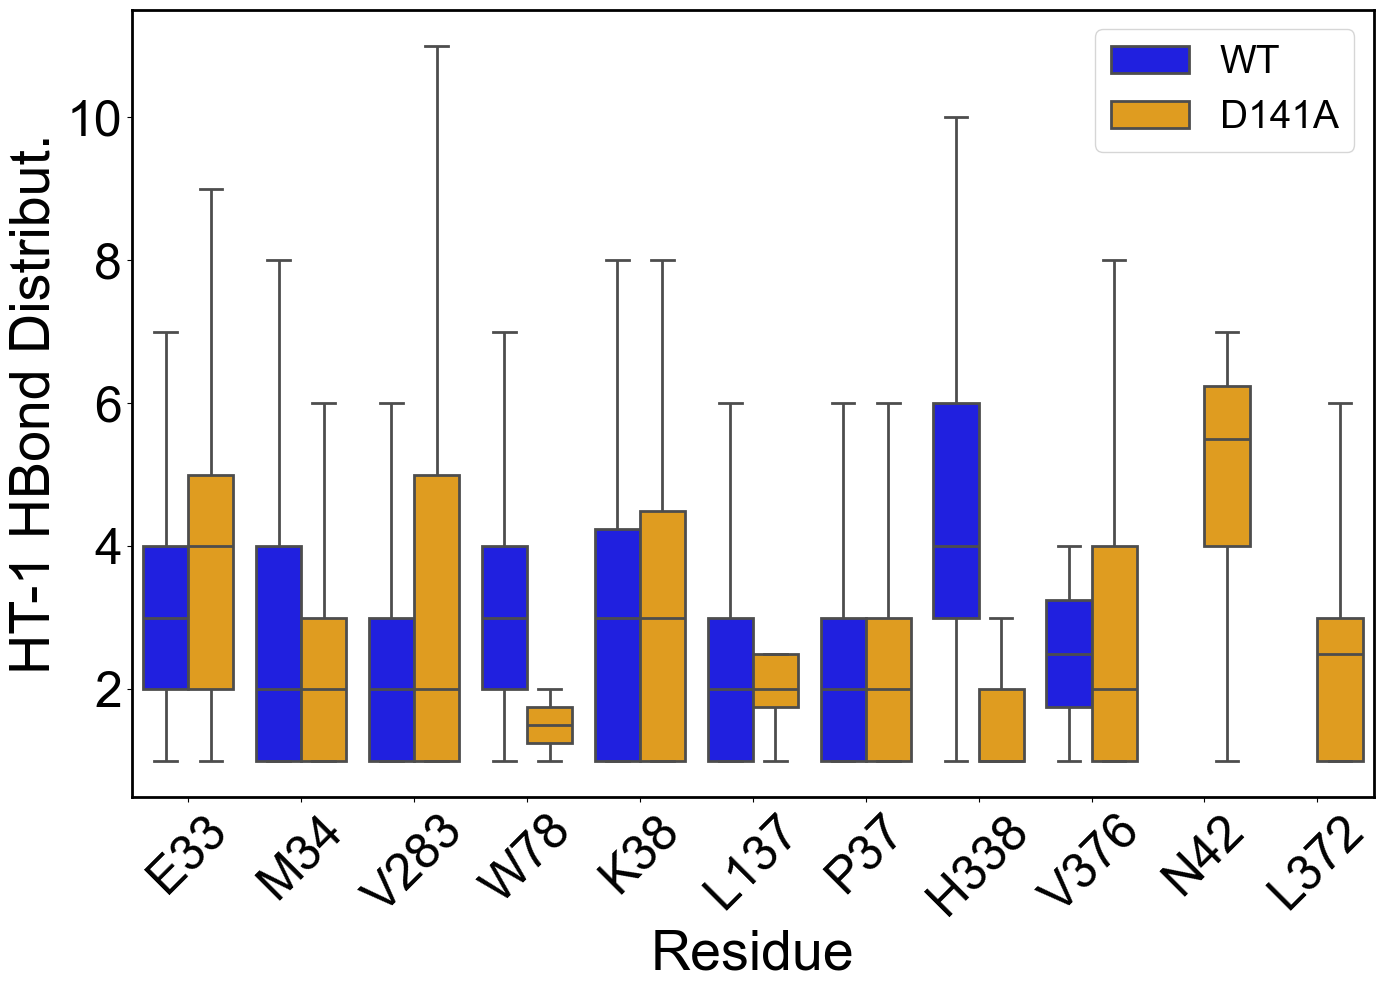

In [151]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager

# Mapping three-letter amino acid codes to one-letter codes
three_to_one_map = {
    "ALA": "A", "CYS": "C", "ASP": "D", "GLU": "E", "PHE": "F", "GLY": "G",
    "HIS": "H", "ILE": "I", "LYS": "K", "LEU": "L", "MET": "M", "ASN": "N",
    "PRO": "P", "GLN": "Q", "ARG": "R", "SER": "S", "THR": "T", "VAL": "V",
    "TRP": "W", "TYR": "Y", "HSD": "H"
}

# Function to convert three-letter residue labels to one-letter
def convert_to_one_letter(residue_label):
    """Convert residue label from 'GLU33' to 'E33'."""
    if len(residue_label) < 4:
        # Handle unexpected formats
        return residue_label
    aa_three = residue_label[:3].upper()
    number = residue_label[3:]
    aa_one = three_to_one_map.get(aa_three, aa_three)  # Default to three-letter code if not found
    return f"{aa_one}{number}"

# Ensure the dataframe is not empty
if not df_all.empty:
    print("氢键统计示例(前5行):")
    print(df_all.head())

    # 统计平均氢键数（按残基）
    avg_hbond = df_all.groupby("residue_label")["hbond_count"].mean().sort_values(ascending=False)
    print("平均氢键数最高的前 5 个残基:")
    print(avg_hbond.head(5))

    # 简易可视化：选取平均氢键数大于某阈值的残基
    threshold = 2.5
    residues_of_interest = avg_hbond[avg_hbond >= threshold].index.tolist()
    if residues_of_interest:
        # Filter the data for residues of interest
        plot_data = df_all[df_all["residue_label"].isin(residues_of_interest)].copy()

        # Update residue labels to use single-letter amino acid codes
        plot_data["residue_label"] = plot_data["residue_label"].apply(convert_to_one_letter)

        # Replace "Mutant" with "D141A" in the 'system' column
        plot_data["system"] = plot_data["system"].replace({"Mutant": "D141A"})

        # Verify the replacement (optional but recommended)
        print("Unique systems after replacement:", plot_data["system"].unique())

        # Verify the conversion of residue labels
        print("Sample converted residue labels:")
        print(plot_data["residue_label"].head())

        # Figure setup
        plt.figure(figsize=(14, 10))

        # Create a box plot
        sns.boxplot(
            data=plot_data,
            x="residue_label",
            y="hbond_count",
            hue="system",
            palette={"WT": "blue", "D141A": "orange"},  # Updated palette with "D141A"
            showfliers=False,  # Do not show outliers
            linewidth=2  # Thicker lines for the boxplot
        )

        # Title and labels
        plt.xlabel("Residue", fontsize=40, fontname='Arial')
        plt.ylabel("HT-1 HBond Distribut.", fontsize=40, fontname='Arial')

        # Tick parameters
        plt.xticks(fontsize=36, fontname='Arial', rotation=45)
        plt.yticks(fontsize=36, fontname='Arial')

        # Thicker border
        ax = plt.gca()
        for spine in ax.spines.values():
            spine.set_linewidth(2)

        # Customize legend
        legend_font = font_manager.FontProperties(family='Arial', size=28)
        plt.legend(
            title_fontsize=28,
            fontsize=28,
            prop=legend_font,
            loc='upper right',
            frameon=True
        )

        # Layout
        plt.tight_layout()

        # Optional: save the figure
        save_path = "/Scr/yunsenz2/data/BmrCD/figure/HT-1_HBond_Boxplot.png"
        plt.savefig(save_path, dpi=300, bbox_inches='tight', format='png')

        # Show plot
        plt.show()
    else:
        print(f"没有残基的平均氢键数 >= {threshold}。")
else:
    print("警告：无氢键统计数据，可能因选择器/阈值过于严格或未检测到跨配体-蛋白氢键。")


df_merged.head():


,frame,time,residue_label,hbond_count,system,traj_file,Chain
0,0,0.0,E33,1,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,C
1,0,0.0,M34,3,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,C
2,0,0.0,V283,1,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,C
3,0,0.0,W78,1,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,C
4,5,10.0,K38,2,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,C
5,5,10.0,L137,1,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,C
6,5,10.0,M34,4,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,C
7,5,10.0,P37,3,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,C
8,5,10.0,W78,7,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,C
9,10,20.0,E33,1,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,C


合并并替换后，链ID汇总:
Chain
BmrC    7876
BmrD    1371
Name: count, dtype: int64
Unique systems after replacement: ['WT' 'D141A']
符合阈值的残基数: 11
plot_data 行数: 9247


,frame,time,residue_label,hbond_count,system,traj_file,Chain
0,0,0.0,E33,1,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,BmrC
1,0,0.0,M34,3,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,BmrC
2,0,0.0,V283,1,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,BmrC
3,0,0.0,W78,1,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,BmrC
4,5,10.0,K38,2,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,BmrC
5,5,10.0,L137,1,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,BmrC
6,5,10.0,M34,4,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,BmrC
7,5,10.0,P37,3,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,BmrC
8,5,10.0,W78,7,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,BmrC
9,10,20.0,E33,1,WT,/Scr/msincla01/BmrCD/of-state/analysis/trajs/r...,BmrC


BmrC 残基数: 8
BmrD 残基数: 3


/tmp/ipykernel_3565795/1433468113.py:80: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


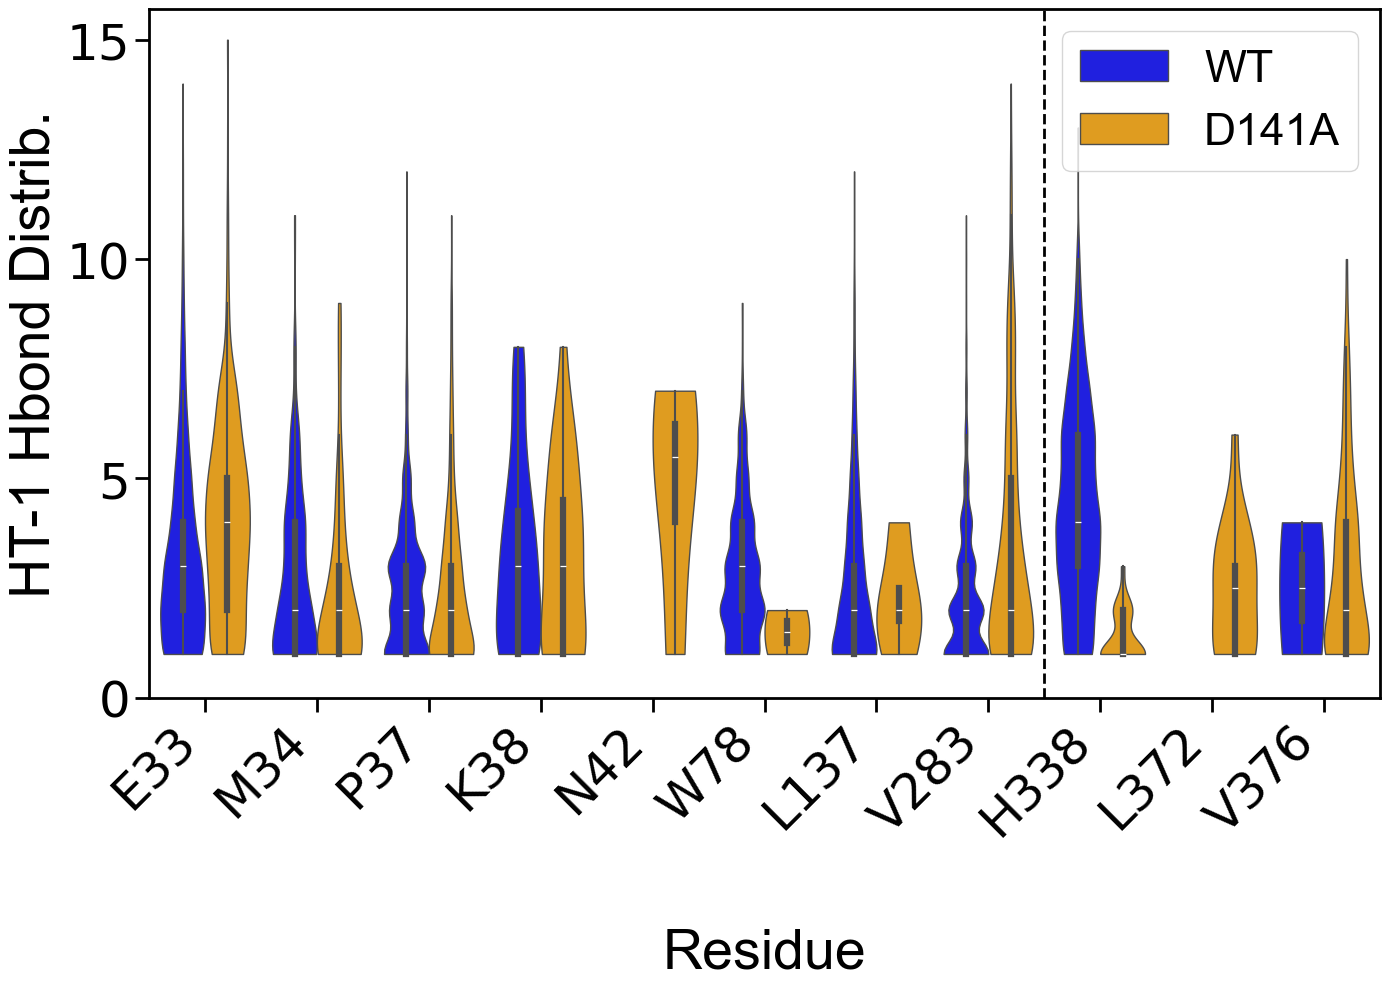


链 BmrC 包含以下残基:
E33, M34, P37, K38, N42, W78, L137, V283

链 BmrD 包含以下残基:
H338, L372, V376


In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager

# 假设 df_psf 和 plot_data 已经定义
if df_psf is not None and not plot_data.empty:
    df_merged = pd.merge(plot_data, df_psf, on='residue_label', how='left')
    
    # 无法匹配的先填充 Unknown
    missing = df_merged['Chain'].isnull().sum()
    if missing > 0:
        print(f"警告: 有 {missing} 个残基未匹配到链信息, 填充为Unknown。")
        df_merged['Chain'] = df_merged['Chain'].fillna("Unknown")
    
    print("df_merged.head():")
    display(df_merged.head(10))
    
    # 如果实际的链ID为 "C"/"D"，而我们想把它命名为 "BmrC"/"BmrD"
    chain_replace_dict = {"C": "BmrC", "D": "BmrD"}
    df_merged['Chain'] = df_merged['Chain'].replace(chain_replace_dict)
    
    print("合并并替换后，链ID汇总:")
    print(df_merged['Chain'].value_counts(dropna=False))
    
    # 替换 'Mutant' & 'MT' => 'D141A'
    df_merged["system"] = df_merged["system"].replace({"Mutant": "D141A", "MT": "D141A"})
    unique_systems = df_merged["system"].unique()
    print("Unique systems after replacement:", unique_systems)

    # 定义调色板
    palette = {
        "D141A": "orange",  # 自定义颜色
        "WT": "blue"         # 自定义颜色
    }
    
    # -------------------------------
    # 7) 根据阈值筛选感兴趣残基
    # -------------------------------
    contact_threshold = 1.0  # 可根据需要调整阈值
    residues_of_interest = (
        df_merged.groupby("residue_label")["hbond_count"]
        .mean()
        .loc[lambda x: x >= contact_threshold]
        .index.tolist()
    )
    
    print("符合阈值的残基数:", len(residues_of_interest))
    if len(residues_of_interest) < 1:
        print("Warning: 没有任何残基均值超过阈值，无法绘图。")
    else:
        df_all = df_merged[df_merged["residue_label"].isin(residues_of_interest)].copy()
        print("plot_data 行数:", len(df_all))
        display(df_all.head(10))
        
        if 'Chain' not in df_all.columns:
            print("错误: 'Chain' 列不存在于合并后的数据框中。")
        else:
            # -------------------------------
            # 8) 用 violinplot 单轴绘图
            # -------------------------------
            
            # 分别获取 BmrC / BmrD 的残基，并排序
            chainC = df_all.loc[df_all["Chain"]=="BmrC","residue_label"].unique().tolist()
            chainD = df_all.loc[df_all["Chain"]=="BmrD","residue_label"].unique().tolist()
            
            def residue_num(res):
                return int("".join(filter(str.isdigit, res)))  # 提取数字用于排序
            
            chainC_sorted = sorted(chainC, key=residue_num)
            chainD_sorted = sorted(chainD, key=residue_num)
            residue_order = chainC_sorted + chainD_sorted
            
            print("BmrC 残基数:", len(chainC_sorted))
            print("BmrD 残基数:", len(chainD_sorted))
            
            fig = plt.figure(figsize=(14, 10))
            ax = fig.add_subplot(111)
            
            ax = sns.violinplot(
                data=df_all,
                x="residue_label",
                y="hbond_count",
                hue="system",
                order=residue_order,
                palette=palette,
                cut=0,
                scale="width",
                linewidth=1,
                ax=ax
            )
            
            # 中间分隔线（BmrC和BmrD的交界）
            plt.axvline(
                x=len(chainC_sorted)-0.5, 
                color='black', 
                linestyle='--', 
                linewidth=2
            )
                # 让坐标轴边框更粗
            for spine in ax.spines.values():
                spine.set_linewidth(2)
            # 坐标轴 & 刻度
            # 调整刻度线宽度和长度
            ax.tick_params(axis='both', which='major', width=2, length=10)
            ax.set_xlabel("Residue", fontsize=40, fontname='Arial', labelpad=60)  # 调整 Residue 标签的位置
            ax.set_ylabel("HT-1 Hbond Distrib.", fontsize=40, fontname='Arial')
            ax.tick_params(axis='x', labelsize=36)
            ax.tick_params(axis='y', labelsize=36)
            plt.xticks(rotation=45, ha='right')

            # 加粗边框
            for spine in ax.spines.values():
                spine.set_linewidth(2)
            
            # 为了能在下方画花括号，我们手动稍微扩展一下下边距
            plt.subplots_adjust(bottom=0.0)
            
            # 先获取当前 y 轴范围
            y_min, y_max = ax.get_ylim()
            # 我们让下限进一步下移，如 -18
            new_ymin = min(y_min, 0)
            ax.set_ylim(new_ymin, y_max)
            
            # 在绘图区域的外部添加 BmrC 和 BmrD 的文本标签
            # 使用 fig.text() 将标签放在绘图区域的外部
            fig.text(
                (x_left_brace_start + x_left_brace_end) / 2 / len(residue_order),  # x 位置居中
                0.08,  # y 位置，调整到绘图区域的外部
                "", 
                fontsize=32, 
                ha='center', 
                va='center', 
                fontname='Arial'
            )

            fig.text(
                (x_right_brace_start + x_right_brace_end) / 2 / len(residue_order),  # x 位置居中
                0.08,  # y 位置，调整到绘图区域的外部
                "", 
                fontsize=32, 
                ha='center', 
                va='center', 
                fontname='Arial'
            )
            
            # 图例
            legend_font = font_manager.FontProperties(family='Arial', size=32)
            ax.legend(
                title_fontsize=32,
                prop=legend_font,
                loc='upper right',
                frameon=True
            )
            
            plt.tight_layout()
            
            save_path = "/Scr/yunsenz2/data/BmrCD/figure/HT1_hb_distribution.png"
            plt.savefig(save_path, dpi=300, bbox_inches='tight', format='png')
            plt.show()
            
            # -------------------------------
            # 9) 可选：打印每条链的残基
            # -------------------------------
            chain_dict = {}
            for index, row in df_all.iterrows():
                ch = row['Chain']
                res = row['residue_label']
                if ch not in chain_dict:
                    chain_dict[ch] = set()
                chain_dict[ch].add(res)
            
            for ch, residues in chain_dict.items():
                sorted_res = sorted(residues, key=lambda x: int("".join(filter(str.isdigit, x))))
                print(f"\n链 {ch} 包含以下残基:")
                print(", ".join(sorted_res))

[信息] 计算 WT 中 /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep1.dcd 的距离随时间...


/Scr/yunsenz2/data/software/miniconda3/envs/mdanalysis/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


[信息] 计算 WT 中 /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep2.dcd 的距离随时间...
[信息] 计算 WT 中 /Scr/msincla01/BmrCD/of-state/analysis/trajs/rep4.dcd 的距离随时间...
[信息] 计算 D141A 中 /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep1.dcd 的距离随时间...
[信息] 计算 D141A 中 /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep2.dcd 的距离随时间...
[信息] 计算 D141A 中 /Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep3.dcd 的距离随时间...
[信息] 合并后数据形状: (23592, 5)
   frame  time  distance system  \
0      0   0.0  1.768279     WT   
1      1   2.0  1.656174     WT   
2      2   4.0  1.653343     WT   
3      3   6.0  1.696440     WT   
4      4   8.0  1.800239     WT   

                                           traj_file  
0  /Scr/msincla01/BmrCD/of-state/analysis/trajs/r...  
1  /Scr/msincla01/BmrCD/of-state/analysis/trajs/r...  
2  /Scr/msincla01/BmrCD/of-state/analysis/trajs/r...  
3  /Scr/msincla01/BmrCD/of-state/analysis/trajs/r...  
4  /Scr/msincla01/BmrCD/of-state/analysis/trajs/r...  


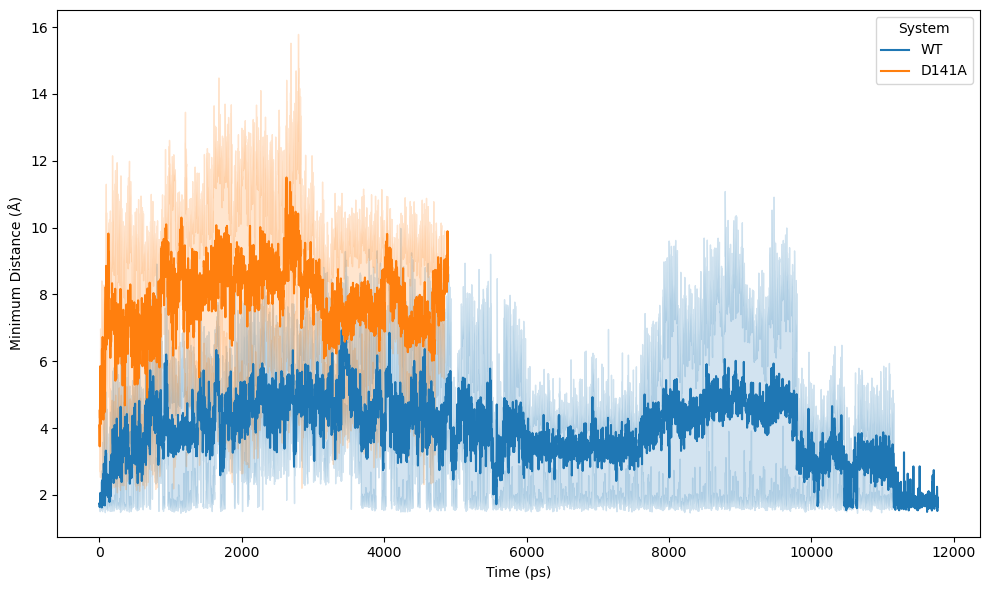

In [146]:
import MDAnalysis as mda
import MDAnalysis.lib.distances
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def load_single_trajectory(psf_file, dcd_file):
    """
    载入单条 PSF + DCD 轨迹，返回 Universe 对象。
    """
    u = mda.Universe(psf_file, dcd_file)
    return u

def compute_min_distance_timeseries(psf_file,
                                    dcd_file,
                                    ligand_sel,
                                    residue_sel,
                                    dt=2.0,
                                    system_label="WT"):
    """
    计算配体 (ligand_sel) 与指定残基 (residue_sel) 在每帧的最小距离 (Å) 随时间的变化。
    返回 DataFrame，包含列: [frame, time, distance, system, traj_file]
      - frame: 帧编号
      - time: 时间 (ps)，由 frame * dt 计算
      - distance: 该帧下配体与残基间的最小距离 (Å)
      - system: 体系标记 (WT 或 D141A)
      - traj_file: DCD 文件路径（或其他标记）
    """
    # 载入轨迹
    u = load_single_trajectory(psf_file, dcd_file)
    ligand_atoms = u.select_atoms(ligand_sel)
    target_res_atoms = u.select_atoms(residue_sel)

    # 如果没找到配体或残基，返回空表
    if len(ligand_atoms) == 0:
        print(f"[警告] 在 {dcd_file} 中未找到配体: {ligand_sel}")
        return pd.DataFrame(columns=["frame", "time", "distance", "system", "traj_file"])
    if len(target_res_atoms) == 0:
        print(f"[警告] 在 {dcd_file} 中未找到目标残基: {residue_sel}")
        return pd.DataFrame(columns=["frame", "time", "distance", "system", "traj_file"])

    records = []
    for ts in u.trajectory:
        frame = ts.frame
        current_time = frame * dt  # 时间(ps)，根据帧号 * dt

        # 计算最小距离: 使用 MDAnalysis.lib.distances.distance_array
        dist_array = mda.lib.distances.distance_array(ligand_atoms.positions,
                                                      target_res_atoms.positions)
        min_dist = dist_array.min()  # 取矩阵中最小值

        records.append((frame, current_time, min_dist, system_label, dcd_file))

    df = pd.DataFrame(records, columns=["frame", "time", "distance", "system", "traj_file"])
    return df

# -------------------- 以下为示例使用代码 --------------------

# 1. 定义WT和D141A的文件路径及轨迹列表
wt_psf = "/Scr/msincla01/BmrCD/of-state/analysis/trajs/rep1.psf"
wt_dcd_list = [
    "/Scr/msincla01/BmrCD/of-state/analysis/trajs/rep1.dcd",
    "/Scr/msincla01/BmrCD/of-state/analysis/trajs/rep2.dcd",
    "/Scr/msincla01/BmrCD/of-state/analysis/trajs/rep4.dcd"
]

mut_psf = "/Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep1.psf"
mut_dcd_list = [
    "/Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep1.dcd",
    "/Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep2.dcd",
    "/Scr/msincla01/BmrCD/of-state/analysis/trajs/d141a_rep3.dcd"
]

# 2. 定义配体和目标残基的选择器
# 对 WT: 配体 resid 3 and resname HT1, 残基 ASP141
wt_ligand_sel = "resid 3 and resname HT1"
wt_residue_sel = "resid 141 and resname ASP"

# 对 Mutant: 配体 resid 3 and resname HT1, 残基 ALA141
mut_ligand_sel = "resid 3 and resname HT1"
mut_residue_sel = "resid 141 and resname ALA"

# 3. 逐个轨迹计算并合并
df_wt_all = []
for dcd_file in wt_dcd_list:
    print(f"[信息] 计算 WT 中 {dcd_file} 的距离随时间...")
    df_wt = compute_min_distance_timeseries(
        psf_file=wt_psf,
        dcd_file=dcd_file,
        ligand_sel=wt_ligand_sel,
        residue_sel=wt_residue_sel,
        dt=2.0,  # 每帧对应 2 ps
        system_label="WT"
    )
    df_wt_all.append(df_wt)

df_wt_combined = pd.concat(df_wt_all, ignore_index=True) if df_wt_all else pd.DataFrame()

df_D141A_all = []
for dcd_file in mut_dcd_list:
    print(f"[信息] 计算 D141A 中 {dcd_file} 的距离随时间...")
    df_D141A = compute_min_distance_timeseries(
        psf_file=mut_psf,
        dcd_file=dcd_file,
        ligand_sel=mut_ligand_sel,
        residue_sel=mut_residue_sel,
        dt=2.0,  # 每帧对应 2 ps
        system_label="D141A"
    )
    df_D141A_all.append(df_D141A)

df_D141A_combined = pd.concat(df_D141A_all, ignore_index=True) if df_D141A_all else pd.DataFrame()

# 4. 合并WT和D141A
df_all = pd.concat([df_wt_combined, df_D141A_combined], ignore_index=True) if not df_wt_combined.empty or not df_D141A_combined.empty else pd.DataFrame()

print("[信息] 合并后数据形状:", df_all.shape)
if not df_all.empty:
    print(df_all.head())

# 5. 简单可视化示例
if not df_all.empty:
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_all, x="time", y="distance", hue="system")
    plt.xlabel("Time (ps)")
    plt.ylabel("Minimum Distance (Å)")
#    plt.title("Distance: Ligand (resid 3, resname HT1) vs. Residue 141 (ASP/ALA)")
    plt.legend(title="System")
    plt.tight_layout()
    plt.savefig("Ligand_Res141_distance.png", dpi=300)
    plt.show()
else:
    print("[警告] df_all 为空，无法进行可视化。")


[信息] 已保存图像到: /Scr/yunsenz2/data/BmrCD/figure/HT1_Res141_distance_mean_std.png


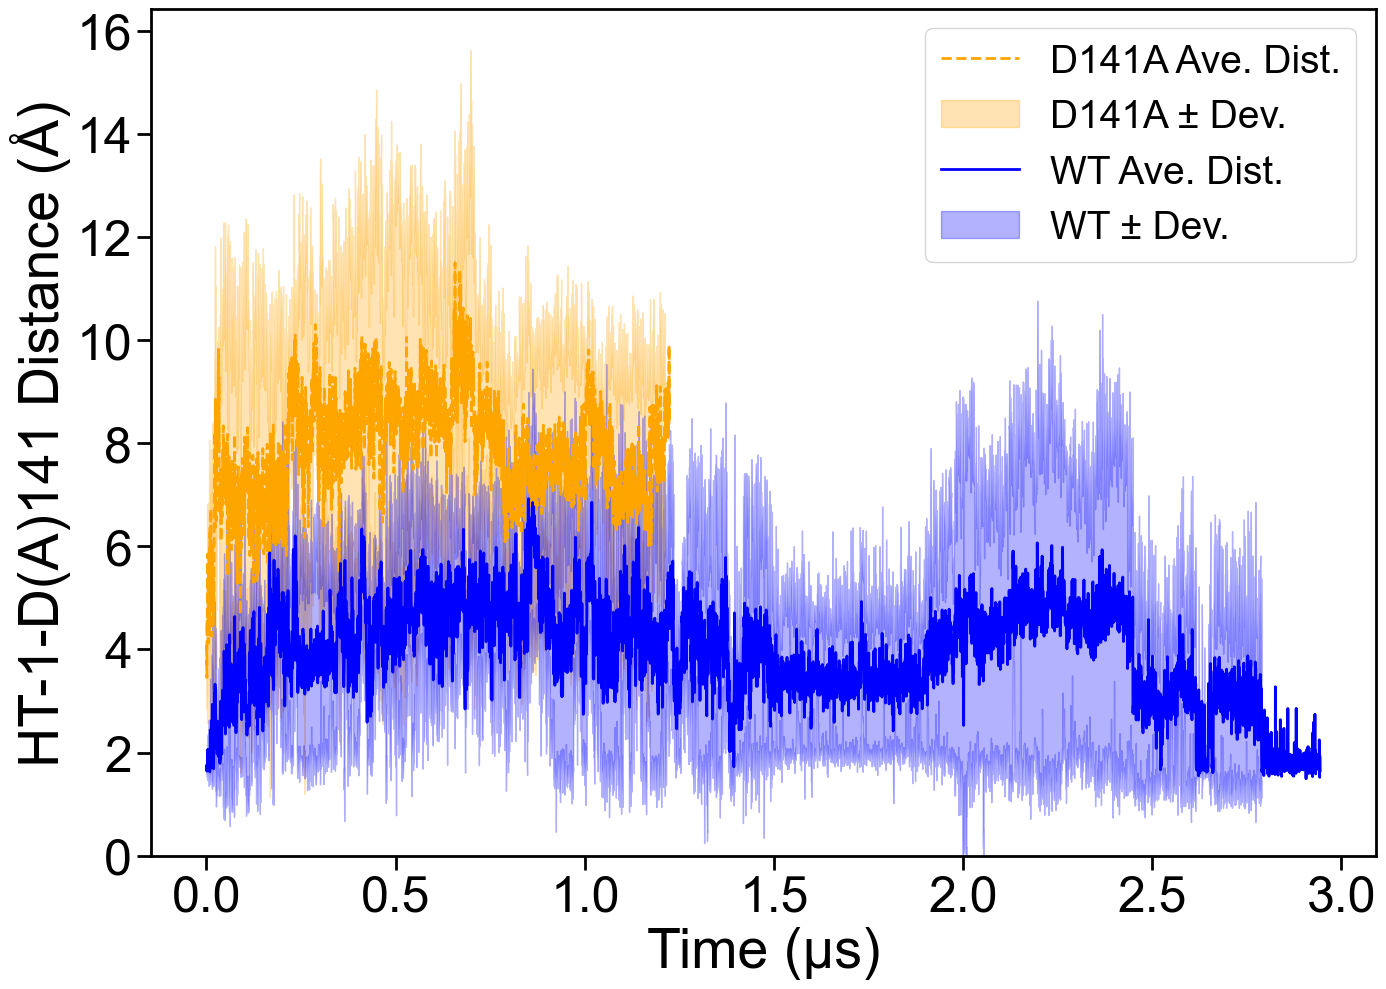

In [147]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import font_manager
from matplotlib.ticker import FuncFormatter

# === 你可以根据需要定义一个比例因子，如 factor = 0.001 用于 ps -> ns
factor = 0.00025  # 示例：将 x 轴缩小到原来的 0.1 倍

# 假设 df_all 是之前合并好的 DataFrame，包含 time、distance、system 列
if df_all.empty:
    print("[警告] df_all 为空，无法进行可视化。")
else:
    # 1. 按 (system, time) 分组，计算 distance 的 mean 和 std
    df_stats = (
        df_all
        .groupby(["system", "time"], as_index=False)
        .agg(mean_dist=("distance", "mean"),
             std_dist=("distance", "std"))
        .fillna({"std_dist": 0.0})
    )

    # 获取所有 system 标签，如 WT、D141A
    systems = df_stats["system"].unique()

    # 创建画布
    plt.figure(figsize=(14, 10))

    # 定义颜色、线型映射
    color_map = {"WT": "blue", "D141A": "orange"}
    linestyle_map = {"WT": "-", "D141A": "--"}

    for sys_label in systems:
        sub = df_stats[df_stats["system"] == sys_label].copy()
        sub = sub.sort_values("time")

        # x 轴做缩放：原 time × factor
        x = sub["time"].values * factor
        y = sub["mean_dist"].values
        y_minus = y - sub["std_dist"].values
        y_plus  = y + sub["std_dist"].values

        # 绘制平均距离曲线
        plt.plot(x, y,
                 color=color_map.get(sys_label, "black"),
                 linestyle=linestyle_map.get(sys_label, "-"),
                 linewidth=2,
                 label=f"{sys_label} Ave. Dist.")

        # 绘制上下标准差区域
        plt.fill_between(x, y_minus, y_plus,
                         color=color_map.get(sys_label, "black"),
                         alpha=0.3,
                         label=f"{sys_label} ± Dev.")
    plt.ylim(0)
    # 自定义坐标轴标签，注意单位是否也要改
    # 例如 factor=0.001 时，你可能把原 ps 改为 ns
    plt.xlabel("Time (μs)", fontsize=40, fontname="Arial")
    plt.ylabel("HT-1-D(A)141 Distance (Å)", fontsize=40, fontname="Arial")
    plt.xticks(fontsize=36, fontname="Arial")
    plt.yticks(fontsize=36, fontname="Arial")

    # 让坐标轴边框更粗
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(2)

    # 定义格式化函数
    def scale_x_ticks(value, pos):
        return f"{value:.1f}"  # 保留一位小数

    def scale_y_ticks(value, pos):
        return f"{value:.0f}"  # 保留一位小数

    # 应用刻度格式
    ax.xaxis.set_major_formatter(FuncFormatter(scale_x_ticks))
    ax.yaxis.set_major_formatter(FuncFormatter(scale_y_ticks))  # 应用于 Y 轴

    # 调整刻度线宽度和长度
    ax.tick_params(axis='both', which='major', width=2, length=10)

    # 图例设置
    legend_font = font_manager.FontProperties(family='Arial', size=28)
    plt.legend(loc='best', prop=legend_font, frameon=True)

    # 调整布局并保存
    plt.tight_layout()
    save_path = "/Scr/yunsenz2/data/BmrCD/figure/HT1_Res141_distance_mean_std.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"[信息] 已保存图像到: {save_path}")

    plt.show()
